# Krypton Lifetime

## Produce lifetime map 

### Author: JJGC

In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Fri Aug 17 10:04:57 2018


### Input files

In [2]:
input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"

input_file_names  = ['dst_6206_0000_9999.h5','dst_6206_10000_19999.h5',
                    'dst_6206_20000_29999.h5','dst_6206_30000_39299.h5']
output_file_name  = 'ldst_6206.h5'
map_file_name     = 'kr_corrections_6206.h5'
bootstrap_correction_filename   = f"$IC_DATA/maps/kr_corrections_run6206.h5"

### Notebook configuration

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [4]:
import os
import time
import datetime 
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings

In [5]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units

In [6]:
from krcal.core.io_functions       import kdst_write
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo

In [325]:
from krcal.core.io_functions            import filenames_from_list
from krcal.core.core_functions          import time_delta_from_time
from krcal.core.analysis_functions      import kr_ranges_and_bins
from krcal.core.analysis_functions      import fiducial_volumes
from krcal.core.analysis_functions      import fid_eff
from krcal.core.analysis_functions      import select_rphi_sectors
from krcal.core.analysis_functions      import plot_sector
from krcal.core.analysis_functions      import plot_sectors
from krcal.core.analysis_functions      import kr_event_selection
from krcal.core.s1s2_functions          import s12_time_profile
from krcal.core.analysis_functions      import select_in_XYRange
from krcal.core.core_functions          import phirad_to_deg
from krcal.core.plt_functions           import plot_xy_density
from krcal.core.plt_functions           import plot_s2e_vs_z_r_regions
from krcal.core.plt_functions           import plot_Eg_vs_z_r_regions
from krcal.core.plt_functions           import plot_s1e_vs_z_r_regions
from krcal.core.plt_functions           import plot_s2e_vs_s1e_r_regions
from krcal.core.plt_functions           import plot_s2q_vs_z_r_regions
from krcal.core.plt_functions           import plot_s2q_vs_s2e_r_regions
from krcal.core.plt_functions           import plot_Qg_vs_z_r_regions
from krcal.core.fit_lt_functions        import fit_lifetime
from krcal.core.fit_lt_functions        import lt_lifetime
from krcal.core.fit_lt_functions        import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_functions        import print_fit_lifetime
from krcal.core.fit_lt_functions        import time_fcs
from krcal.core.fit_lt_functions        import fb_fits
from krcal.core.fit_lt_functions        import fit_fcs_in_sectors
from krcal.core.fit_lt_functions        import lt_maps
from krcal.core.histo_functions         import h1, h1d
from krcal.core.fit_histograms          import histo_fit_fb_pars
from krcal.core.fit_histograms          import plot_fit_fb_pars
from krcal.core.fit_histograms          import print_fit_fb_pars
from krcal.core.fit_histograms          import histo_fit_sectors
from krcal.core.fit_histograms          import print_fit_sectors_pars
from krcal.core.fit_histograms          import plot_fit_sectors

In [269]:
from krcal.core.kr_types import PlotLabels, KrEvent
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core          import fit_functions_ic as fitf

In [337]:
from krcal.core.map_functions   import draw_wedges
from krcal.core.map_functions   import define_rphi_sectors
from krcal.core.map_functions   import rphi_sector_map
#from krcal.core.wedges   import draw_map, draw_map_time_slice

In [11]:
import krcal.dev.corrections       as corrections 


In [12]:
from numpy import pi

In [13]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [11]:
import os
import time
import datetime
import collections
import glob
import warnings
import matplotlib.pyplot as plt

import tables            as tb
import numpy             as np
import matplotlib.dates  as md

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io.dst_io as dstio
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import measurement_string
import invisible_cities.reco    .corrections    as corrf

from icaro.core.fit_functions import quick_gauss_fit
from icaro.core.fit_functions import to_relative
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(True)


In [12]:
from core.kr_types import KrEvent, DstEvent, KrRanges, KrNBins, KrBins, KrFit, XYRanges, Ranges
from core.kr_types import KrMeanAndStd
from core.kr_types import KrLTLimits

from core.kr_core_functions import kr_event
from core.kr_core_functions import kr_times_ranges_and_bins
from core.kr_core_functions import divide_np_arrays
from core.kr_core_functions import file_numbers_from_file_range
from core.kr_core_functions import fiducial_volumes
from   invisible_cities.evm  .ic_containers  import Measurement

In [13]:
import core.kr_histo_functions as krh
import core.kr_core_functions as krc
import core.kr_fit_functions as krf
import core.kr_plt_functions as krp

In [6]:
from   invisible_cities.core.core_functions import weighted_mean_and_std
from   invisible_cities.core.core_functions import loc_elem_1d
from   invisible_cities.types.ic_types import minmax

In [7]:
from icaro.core.fit_functions import expo_seed, gauss_seed

In [8]:
from typing      import NamedTuple

In [74]:
# Plotting style
default_cmap = "jet"
figure_size  = 8, 6
font_size    = 14

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

warnings.filterwarnings('ignore', category=tb.NaturalNameWarning)

profOpt = "--k"
fitOpt  = "r"


In [75]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Input/output 

In [14]:
input_dst_filenames, output_dst_filename, map_filename =filenames_from_list(input_file_names,
                                                                            output_file_name,
                                                                            map_file_name,
                                                                            input_path,
                                                                            output_path,
                                                                            map_path)

In [15]:
print(f'input dsts:\n first = {input_dst_filenames[0]}\n last = {input_dst_filenames[-1]}')
print(f"output dst = {output_dst_filename}")
print(f"map file   = {map_filename}")

input dsts:
 first = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_0000_9999.h5
 last = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_30000_39299.h5
output dst = /Users/jjgomezcadenas/Projects/ICDATA/ldst/ldst_6206.h5
map file   = /Users/jjgomezcadenas/Projects/ICDATA/maps/kr_corrections_6206.h5


In [16]:
dst           = load_dsts(input_dst_filenames, "DST", "Events")

In [17]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {number_of_evts_full}")

Total number of events: 4085430


In [18]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Time differences in seconds

In [19]:
dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Ranges and binning

In [20]:
s1e_range = (2, 30)
s2e_range = (2000, 14000)
s2q_range = (200, 800)
xy_range  = (-220,  220)
z_range   = (10,  550)
krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 12,
                                                        s2enbins  = 50,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

### Corrected S2e and Q

In [21]:
bootstrap_correction_filename = os.path.expandvars(bootstrap_correction_filename)
calibrate = corrections.Calibration(bootstrap_correction_filename)
E, Q = calibrate(dst.X, dst.Y, None, dst.time, dst.S2e, dst.S2q)

calibration file : /Users/jjgomezcadenas/Projects/ICDATA/maps/kr_corrections_run6206.h5
node             : geometry
Energy   scale :  1.0 (pes)
Lifetime scale : 2324.4 (us) 
Charge   scale :  1.0 (pes)


### This defines 4 concentric rings as chamber sectors 

In [22]:
sfull = KrSector(Rmin = 0, Rmax = 200, Phimin=0, Phimax=360)
sfid = KrSector(Rmin = 0, Rmax = 150, Phimin=0, Phimax=360)
score = KrSector(Rmin = 0, Rmax = 100, Phimin=0, Phimax=360)
shcore = KrSector(Rmin = 0, Rmax = 50, Phimin=0, Phimax=360)

In [23]:
krf = fiducial_volumes(dst, DT, E, Q, sectors=(sfull, sfid, score, shcore))

In [24]:
kfull, kfid, kcore, khcore = krf[0], krf[1], krf[2], krf[3]

In [25]:
print(f' full: eff = {fid_eff(dst, kfull)}')
print(f' fid: eff = {fid_eff(dst, kfid)}')
print(f' core: eff = {fid_eff(dst, kcore)}')
print(f' hcore: eff = {fid_eff(dst, khcore)}')

 full: eff = 0.9977380593964406
 fid: eff = 0.5955855320003035
 core: eff = 0.26191441292593437
 hcore: eff = 0.06515593217849773


### Divide chamber in sector of R and Phi

 **The following sectors are considered**

1. 0 <  R < 20  : 0 < Phi < 360
2. 20 < R < 40  : 0 < Phi < 180, 180 < Phi < 360
3. 20 < R < 60  : 0 < Phi < 90, 90 < Phi < 180, 180 < Phi < 270, 270 < Phi < 360
4. 60 < R < 80  : 0 < Phi < 45, 45 < Phi < 90, 90 < Phi < 135, 135 < Phi < 180... until 360
5. 80 < R < 100 : 0 < Phi < 45, 45 < Phi < 90, 90 < Phi < 135, 135 < Phi < 180... until 360

-. From 6 to 10:  100 < R < 200 in steps of 20 and Phi in steps of 45 degrees


In [339]:
R, PHI = rphi_sector_map(nSectors=10)
print(f'sectors on R   = {R}')
print(f'sectors on PHI = {PHI}')

sectors on R   = {0: (0.0, 20.0), 1: (20.0, 40.0), 2: (40.0, 60.0), 3: (60.0, 80.0), 4: (80.0, 100.0), 5: (100.0, 120.0), 6: (120.0, 140.0), 7: (140.0, 160.0), 8: (160.0, 180.0), 9: (180.0, 200.0)}
sectors on PHI = {0: [(0, 360)], 1: [(0, 180), (180, 360)], 2: [(0, 90), (90, 180), (180, 270), (270, 360)], 3: [(0, 45), (45, 90), (90, 135), (135, 180), (180, 225), (225, 270), (270, 315), (315, 360)], 4: [(0, 45), (45, 90), (90, 135), (135, 180), (180, 225), (225, 270), (270, 315), (315, 360)], 5: [(0, 45), (45, 90), (90, 135), (135, 180), (180, 225), (225, 270), (270, 315), (315, 360)], 6: [(0, 45), (45, 90), (90, 135), (135, 180), (180, 225), (225, 270), (270, 315), (315, 360)], 7: [(0, 45), (45, 90), (90, 135), (135, 180), (180, 225), (225, 270), (270, 315), (315, 360)], 8: [(0, 45), (45, 90), (90, 135), (135, 180), (180, 225), (225, 270), (270, 315), (315, 360)], 9: [(0, 45), (45, 90), (90, 135), (135, 180), (180, 225), (225, 270), (270, 315), (315, 360)]}


In [348]:
W = define_rphi_sectors(R, PHI, verbose=False)

In [349]:
W

{0: [KrSector(rmin=0.0, rmax=20.0, phimin=0, phimax=360)],
 1: [KrSector(rmin=20.0, rmax=40.0, phimin=0, phimax=180),
  KrSector(rmin=20.0, rmax=40.0, phimin=180, phimax=360)],
 2: [KrSector(rmin=40.0, rmax=60.0, phimin=0, phimax=90),
  KrSector(rmin=40.0, rmax=60.0, phimin=90, phimax=180),
  KrSector(rmin=40.0, rmax=60.0, phimin=180, phimax=270),
  KrSector(rmin=40.0, rmax=60.0, phimin=270, phimax=360)],
 3: [KrSector(rmin=60.0, rmax=80.0, phimin=0, phimax=45),
  KrSector(rmin=60.0, rmax=80.0, phimin=45, phimax=90),
  KrSector(rmin=60.0, rmax=80.0, phimin=90, phimax=135),
  KrSector(rmin=60.0, rmax=80.0, phimin=135, phimax=180),
  KrSector(rmin=60.0, rmax=80.0, phimin=180, phimax=225),
  KrSector(rmin=60.0, rmax=80.0, phimin=225, phimax=270),
  KrSector(rmin=60.0, rmax=80.0, phimin=270, phimax=315),
  KrSector(rmin=60.0, rmax=80.0, phimin=315, phimax=360)],
 4: [KrSector(rmin=80.0, rmax=100.0, phimin=0, phimax=45),
  KrSector(rmin=80.0, rmax=100.0, phimin=45, phimax=90),
  KrSector(rm

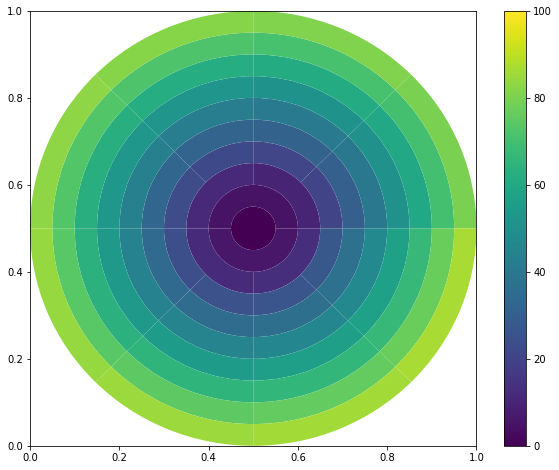

In [351]:
draw_wedges(W, figsize=(10,8), alpha=1.0)

In [299]:
KRES = select_rphi_sectors(dst, DT, E, Q, RPS, verbose = False)

### Time 

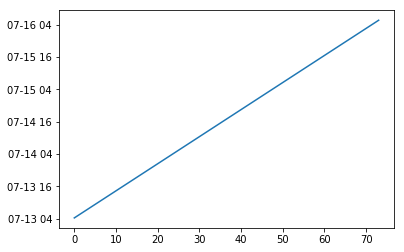

In [31]:
plt.plot(krTimes.timeStamps)

### Event distribution

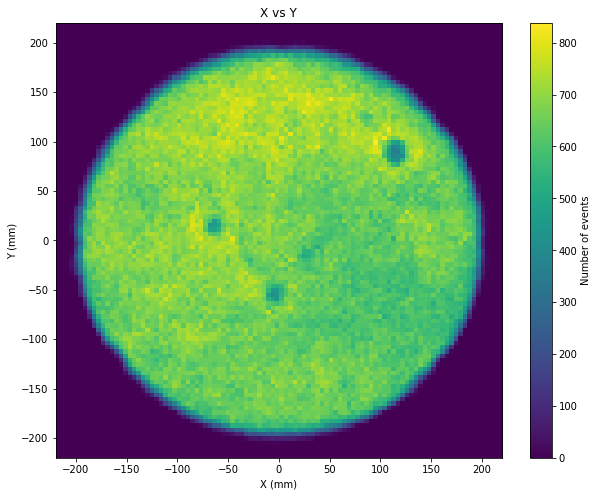

In [32]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

#### Event concentration in the upper part of chamber. This is related with gas flow

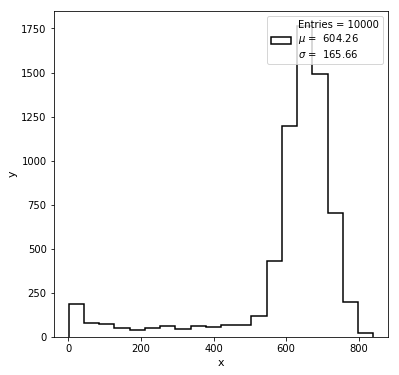

In [33]:
(_) = h1d(nevt.flatten(), bins = 20, range =((1, int(np.max(nevt)) + 2)))

### Events per sector

number of events in sector = 213108.0


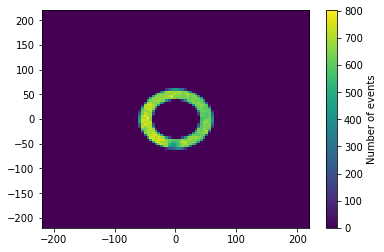

In [37]:
plot_sector(KRES, krNbins.X, krNbins.Y, krRanges.X,krRanges.Y, sector=2)

In [39]:
def plot_sectors(KRES, figsize=(14,14), sectors=range(0,10)):
    fig = plt.figure(figsize=figsize)
    for i in sectors:
        fig.add_subplot(4, 3, i+1)
        plot_sector(KRES, sector=i)

number of events in sector = 43747.0
number of events in sector = 126464.0
number of events in sector = 213108.0
number of events in sector = 299742.0
number of events in sector = 386972.0
number of events in sector = 477252.0
number of events in sector = 569340.0
number of events in sector = 653436.0
number of events in sector = 730688.0
number of events in sector = 575440.0


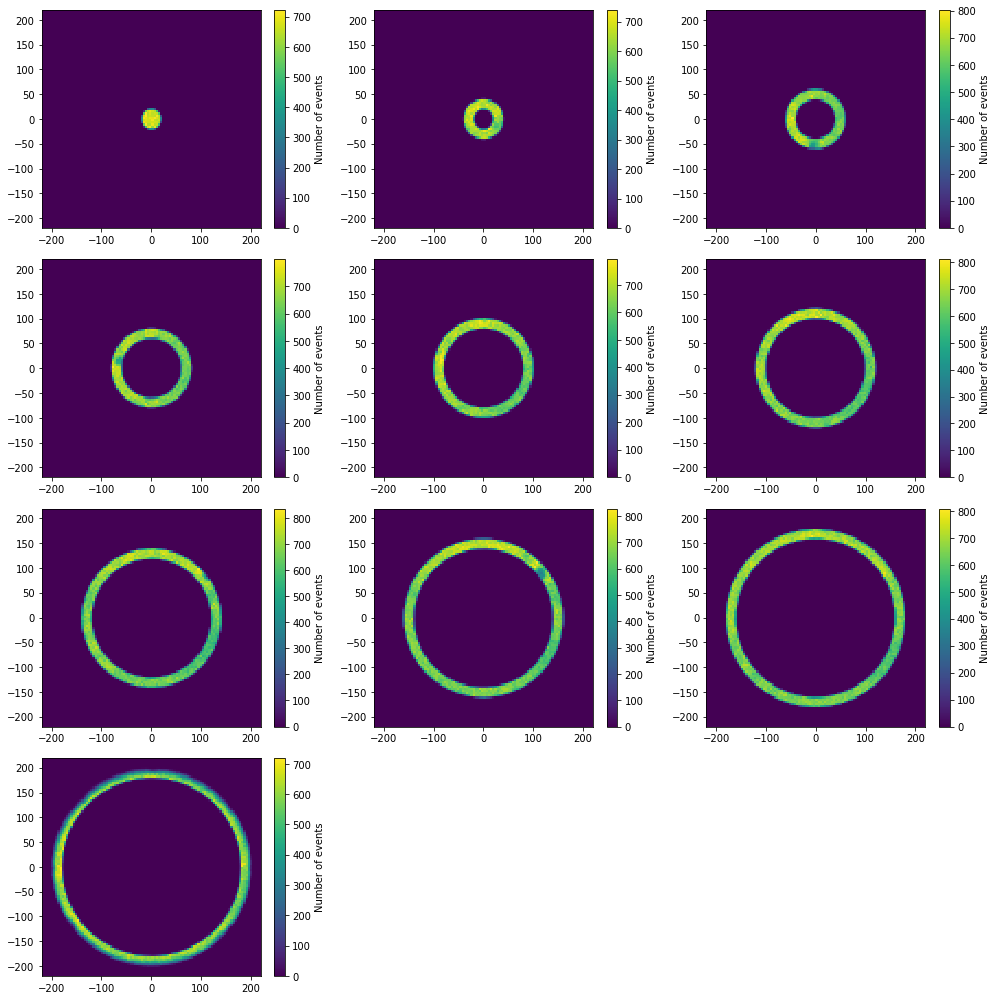

In [38]:
plot_sectors(KRES, krNbins.X, krNbins.Y, krRanges.X,krRanges.Y)

### Evolution of S12 with time 

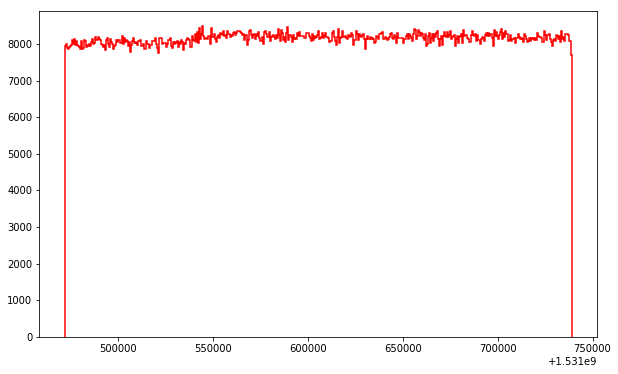

In [57]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
n, b    = h1(kfull.T, bins=500, range = (kfull.T[0], kfull.T[-1]), 
             color='red', stats=False, lbl='time evolution')

#### Full

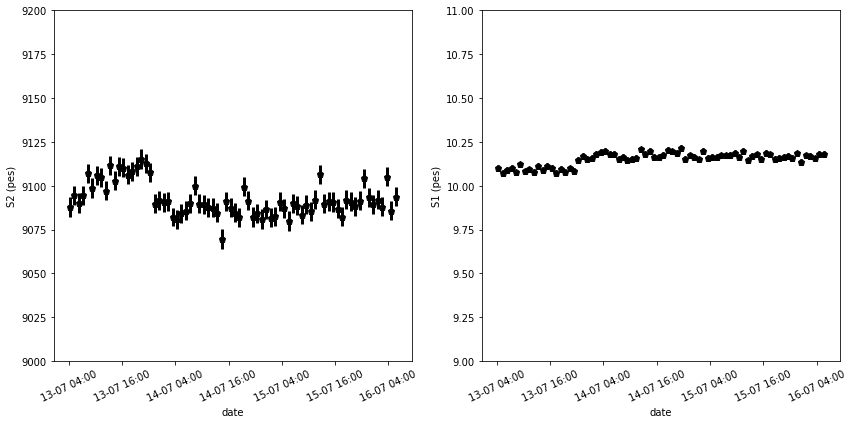

In [58]:
s12_time_profile(kfull, krNbins.T, krRanges.T, krTimes.timeStamps, 
                 s2range=(9000, 9200), 
                 s1range=(9,11), 
                 figsize=(12,6))

#### Fiducial

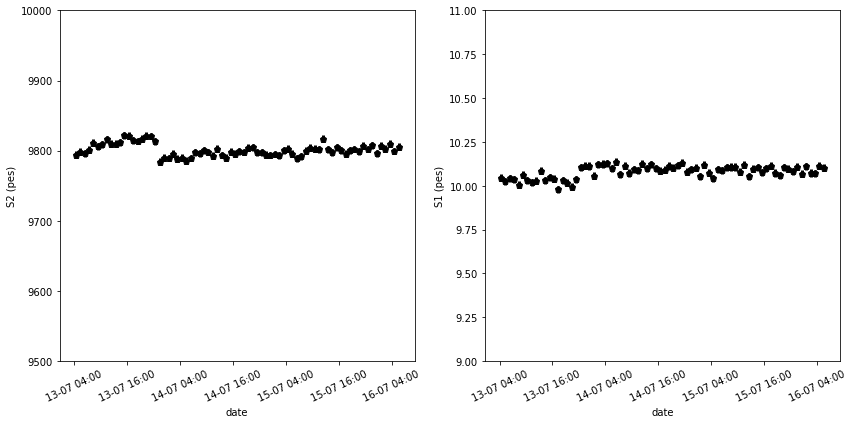

In [59]:
s12_time_profile(kfid, krNbins.T, krRanges.T, krTimes.timeStamps, 
                 s2range=(9500, 10000), 
                 s1range=(9,11), 
                 figsize=(12,6))

#### Core

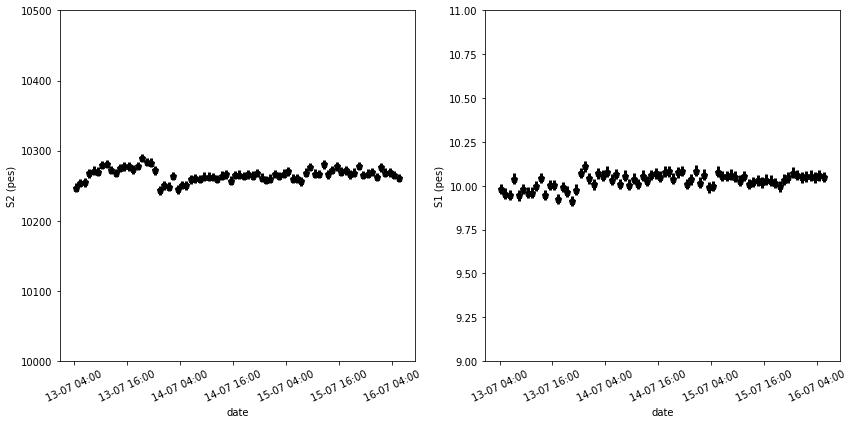

In [60]:
s12_time_profile(kcore, krNbins.T, krRanges.T, krTimes.timeStamps, 
                 s2range=(10000, 10500), 
                 s1range=(9,11), 
                 figsize=(12,6))

#### hard core

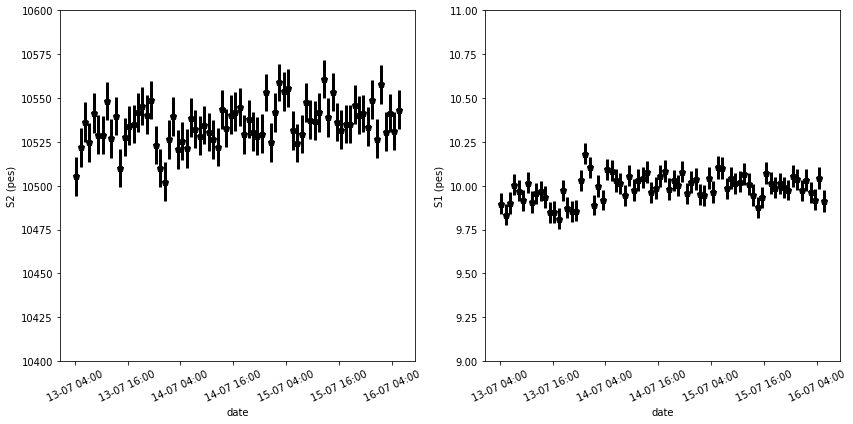

In [61]:
s12_time_profile(khcore, krNbins.T, krRanges.T, krTimes.timeStamps, 
                 s2range=(10400, 10600), 
                 s1range=(9,11), 
                 figsize=(12,6))

### Sector 0

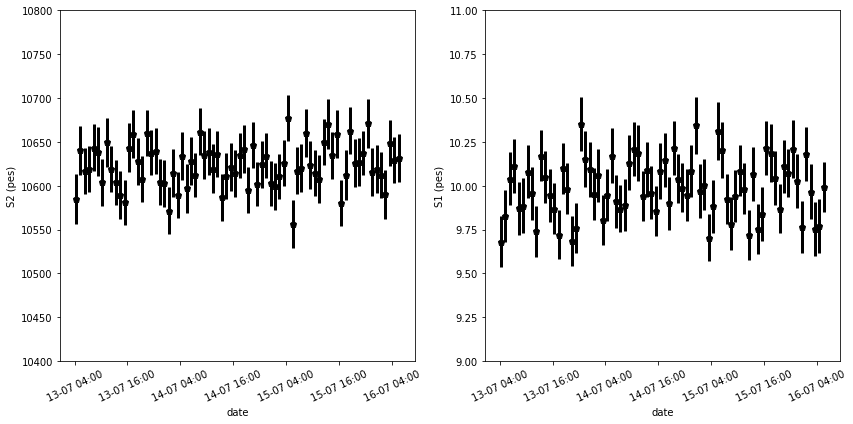

In [40]:
s12_time_profile(KRES[0][0], krNbins.T, krRanges.T, krTimes.timeStamps, 
                 s2range=(10400, 10800), 
                 s1range=(9,11), 
                 figsize=(12,6))

#### S1 and S2 are flat (at large scale) with time, but show small fluctuations, probably due to pressure fluctuations (flux?) Fluctuations in S2 and S2 are anticorrelated (as expected)

### S2e and S2q vs z in regions

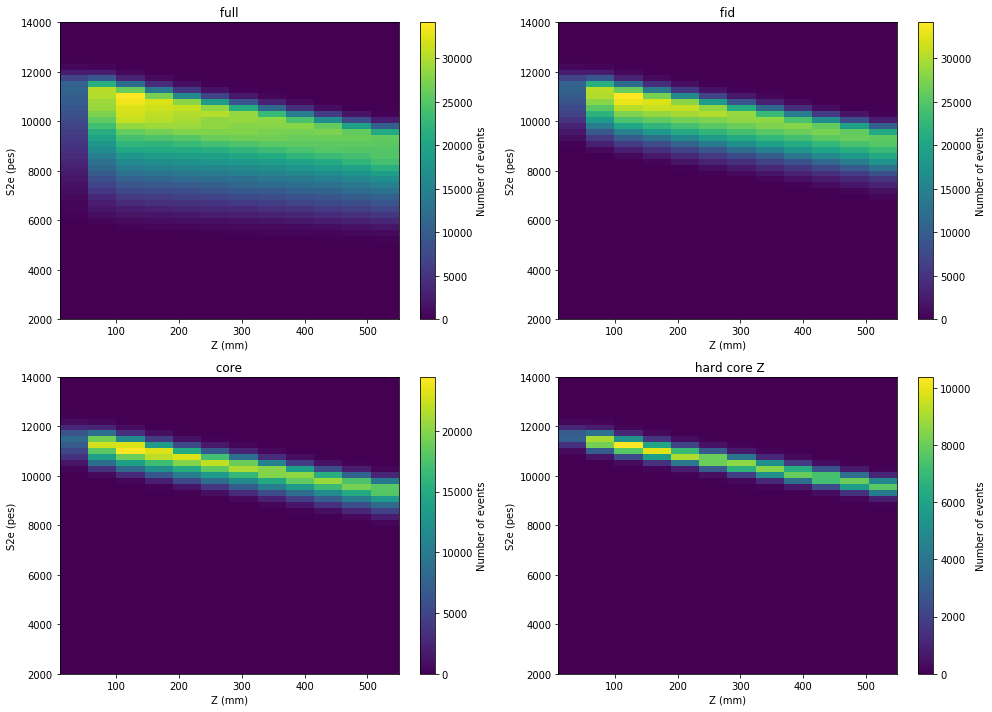

In [41]:
plot_s2e_vs_z_r_regions((kfull, kfid, kcore, khcore), krBins, figsize=(14,10))

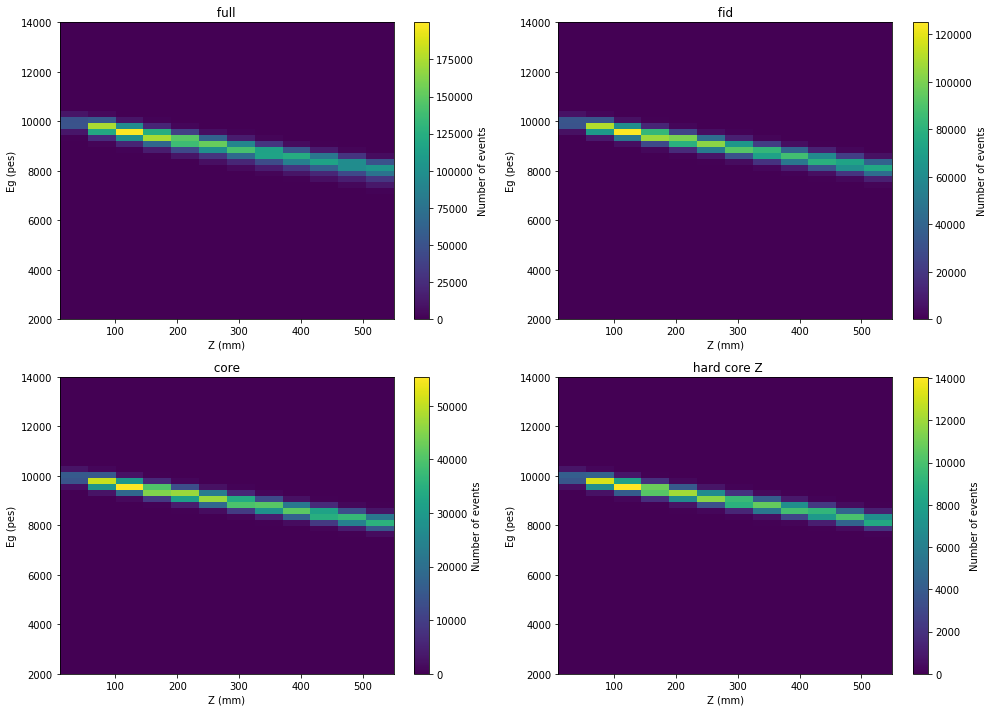

In [42]:
plot_Eg_vs_z_r_regions((kfull, kfid, kcore, khcore), krBins, figsize=(14,10))

#### Notice that geometry corrected energy is the same in all regions

## Lifetime

#### Lifetime may depend:
- on XY position (even more generally on XYZ) due to inhomogenous distributions of impurities (flux related)
- On t (lifetime varies with time).

-Lifetime is determined by dividing the chamber in sectors (R, Rphi) or (X,Y) and fitting an exponential to the energy distribution as a function of Z. The fit yields the lifetime and the value of energy (at z=0) in that sector. 

-The fit must yield a good chi2 (~1). A bad chi2 may signal a variation in the lifetime as a function of (r,phi, t).

#### Example: Fit lifetime in hard core sector (0 < R < 50, -pi < Phi < phi) and in the full time range

In [43]:
fc = fit_lifetime(khcore.Z, khcore.S2e, 
                  nbins_z=krNbins.Z, nbins_e=krNbins.S2e, 
                  range_z=(100,550), range_e=(8000, 12000),
                  fit = FitType.profile)


 Ez0     = 11742.848905698535 +-1.4364315355913955 
 LT      = 2598.330182079628 +-2.5007467686635336 
 chi2    = 3.5579844081517216 


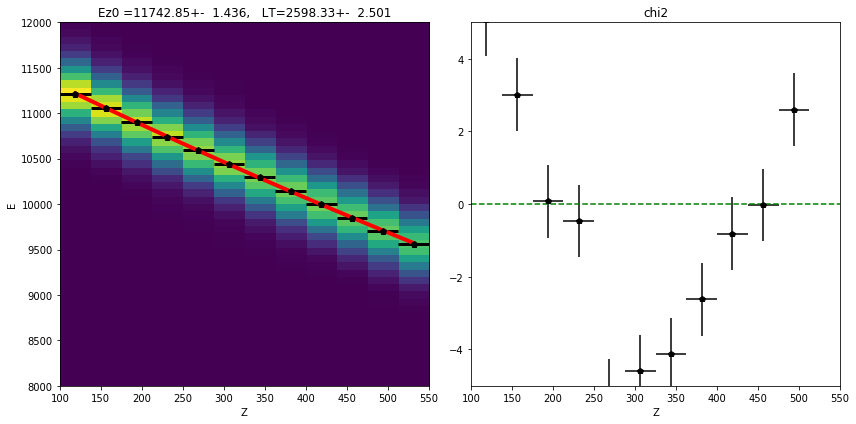

In [44]:
plot_fit_lifetime_and_chi2(fc, figsize=(12,6))
print_fit_lifetime(fc)

#### chi2 value is too high, indicating that lifetime is changing across the span of the fit. The most obvious reason for such a change is a dependence on t

#### Repeat fit using geometry-corrected energy E (should be pretty similar to hcore)

 Ez0     = 10074.505299722963 +-1.0367036513726826 
 LT      = 2594.6393949447324 +-2.17084437147555 
 chi2    = 3.3946266614954475 


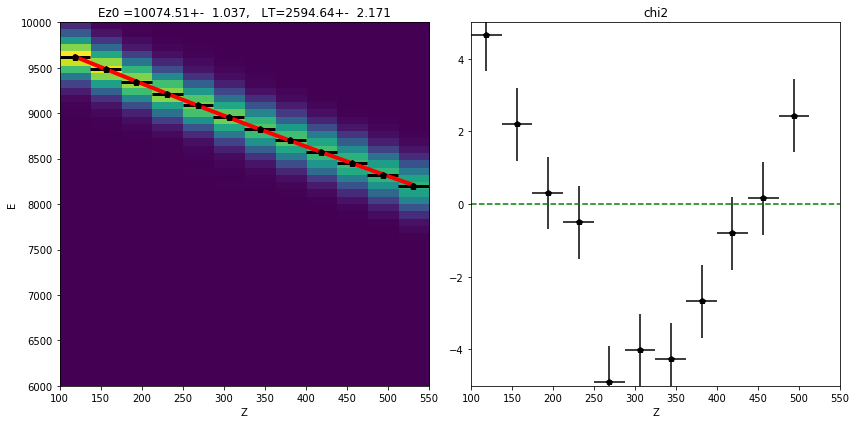

In [45]:
fc = fit_lifetime(khcore.Z, khcore.E, fit = FitType.profile, 
                  nbins_z=krNbins.Z, nbins_e=krNbins.S2e, 
                  range_z=(100,550), range_e=(6000, 10000))
plot_fit_lifetime_and_chi2(fc, figsize=(12,6))
print_fit_lifetime(fc)

### Select in time

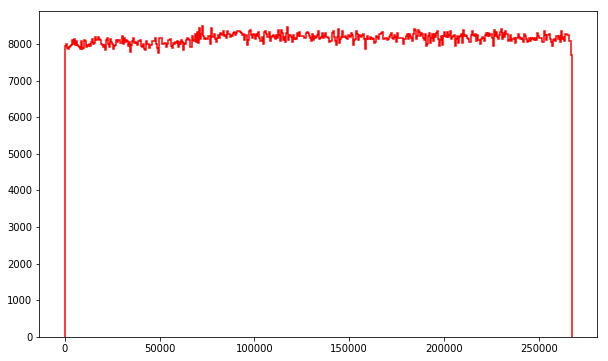

In [31]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
n, b    = h1(kfull.DT, bins=500, range = (kfull.DT[0], kfull.DT[-1]), 
             color='red', stats=False, lbl='time evolution')

### Consider time slices

In [48]:
sel_mask = in_range(khcore.DT, 0, 5e+3)

In [49]:
kct0 =kr_event_selection(khcore,sel_mask)

#### Fit to S2e in the first 5,000 seconds

 Ez0     = 11735.54440281 +-10.501134428089227 
 LT      = 2522.0241964172033 +-17.190018682684922 
 chi2    = 0.9863669321570722 


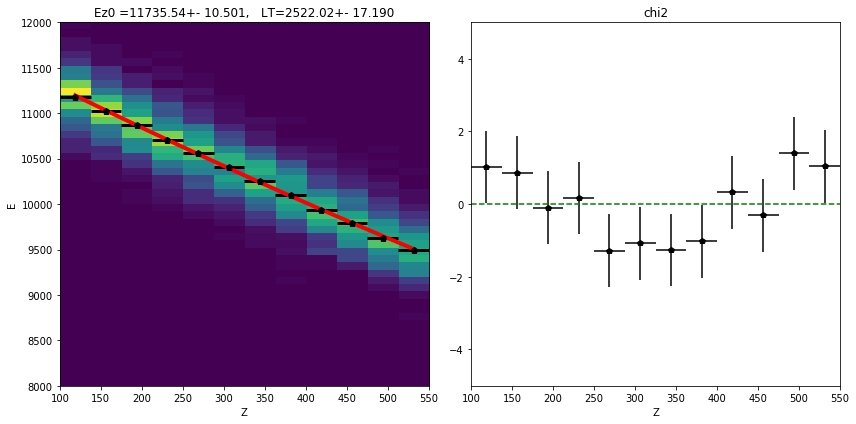

In [50]:
fc = fit_lifetime(kct0.Z, kct0.S2e, fit = FitType.profile, 
                  nbins_z=krNbins.Z, nbins_e=krNbins.S2e, 
                  range_z=(100,550), range_e=(8000, 12000))
plot_fit_lifetime_and_chi2(fc, figsize=(12,6))
print_fit_lifetime(fc)

#### The fit yields good chi2, showing that in hcore and first 5,000 seconds lifetime can be described as a single number for all the chamber

#### Fit to the corrected energy E

 Ez0     = 10076.675095213403 +-7.504559102759094 
 LT      = 2503.370355686178 +-14.51596836744424 
 chi2    = 1.2931844760032576 


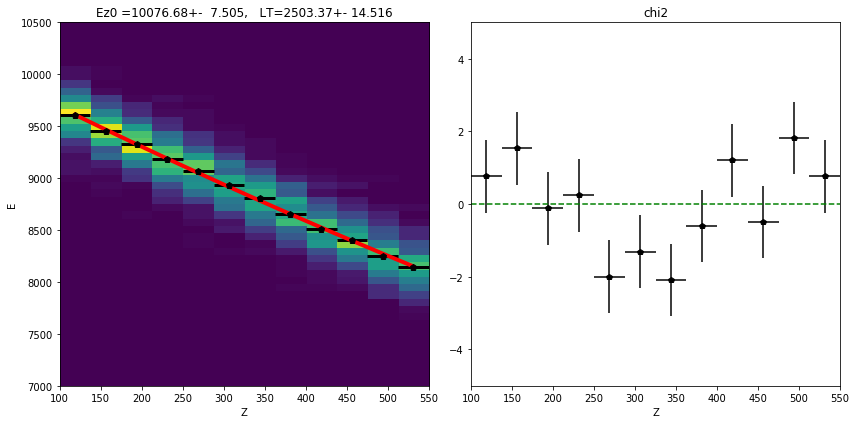

In [51]:
fc = fit_lifetime(kct0.Z, kct0.E, fit = FitType.profile, 
                  nbins_z=krNbins.Z, nbins_e=krNbins.S2e, 
                  range_z=(100,550), range_e=(7000, 10500))
plot_fit_lifetime_and_chi2(fc, figsize=(12,6))
print_fit_lifetime(fc)

#### The chi2 is not as good as S2e, showing a posible bias in the geometrical factors used to correct the energy. 

### Can the data (in time series) be described better by two exponentials fit than by one exponential?

In [52]:
XT = 5000 # time bins

### hard core

#### S2e

In [93]:
fp, fpf, fpb = fb_fits(XT, DT, khcore, krNbins.Z, krNbins.S2e, 
                       range_z=(50,550), 
                       range_zf=(50,300), 
                       range_zb=(300,550), 
                       range_e = (7000, 12000),
                       energy = 'S2e', fit = FitType.profile)

chi2:  full  =     1.02  +-   0.24; front =     0.92 +-   0.23; back  =     0.92 +-   0.19;
e0  :  full  = 11738.00  +-  10.25; front = 11726.50 +-  15.32; back  = 11785.44 +-  37.40;
lt  :  full  =  2606.91  +-  50.59; front =  2649.36 +-  72.05; back  =  2543.55 +-  66.32;


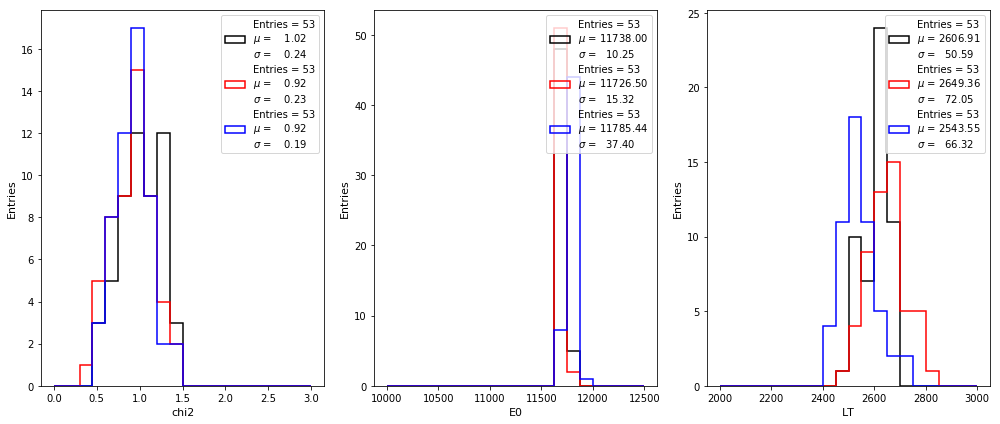

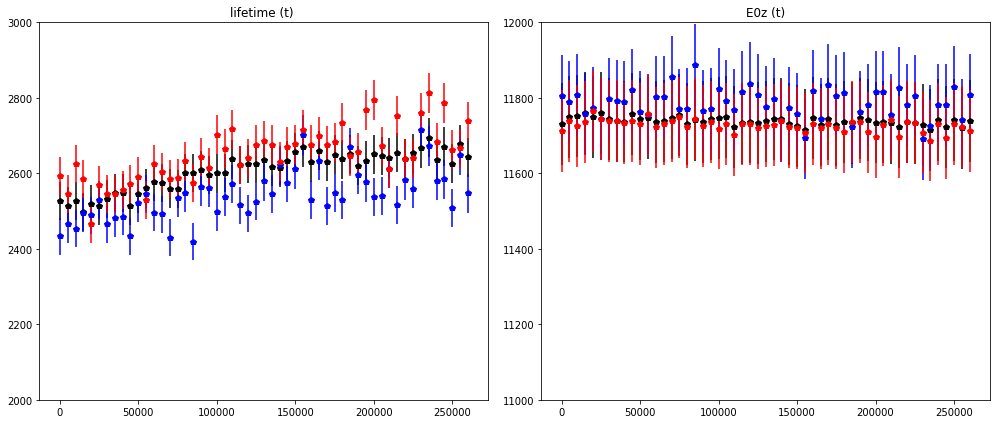

In [99]:
fbp = histo_fit_fb_pars(fp, fpf, fpb)
plot_fit_fb_pars (fp, fpf, fpb)
print_fit_fb_pars(fbp)

#### Fits in hcore: S2e
The fit to a single exponential has good chi2 (~1), and averages the fits in forward and backward part of the chamber. The apparent difference in lifetime forward/backward is anticorrelated with a change in E0. **The data in this region does not support two exponentials rather than one**. 

#### E

In [103]:
fp, fpf, fpb = fb_fits(XT, DT, khcore, krNbins.Z, krNbins.S2e, 
                       range_z=(50,550), 
                       range_zf=(50,300), 
                       range_zb=(300,550), 
                       range_e = (7000, 12000),
                       energy = 'E', fit = FitType.profile)

chi2:  full  =     1.05  +-   0.25; front =     0.86 +-   0.19; back  =     0.92 +-   0.21;
e0  :  full  = 10070.21  +-   8.15; front = 10063.68 +-  11.04; back  = 10107.91 +-  30.14;
lt  :  full  =  2603.64  +-  49.83; front =  2633.93 +-  59.82; back  =  2544.33 +-  63.51;


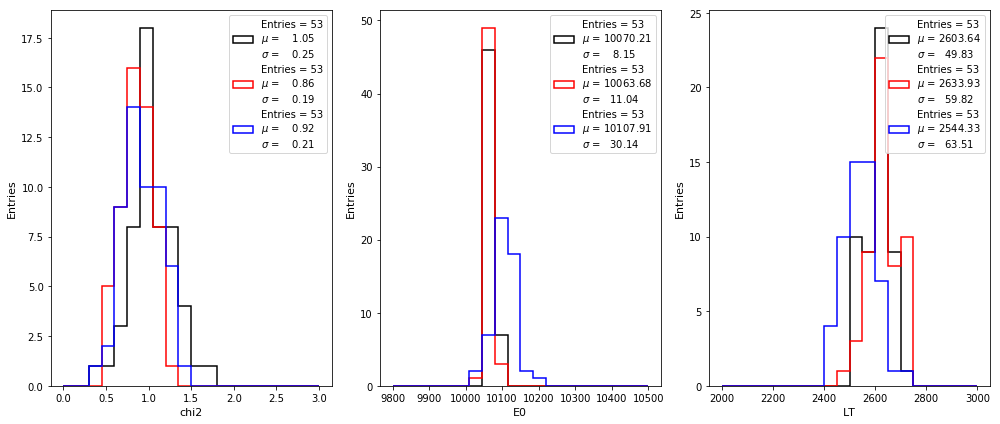

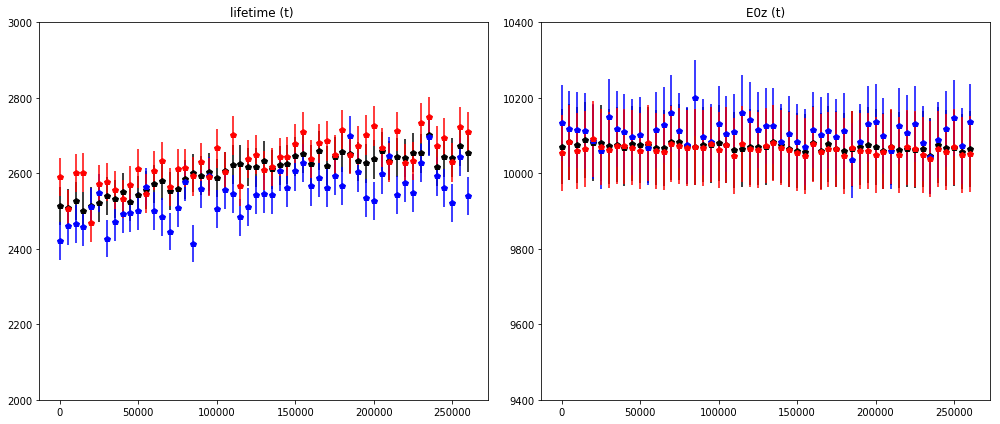

In [102]:
fbp = histo_fit_fb_pars(fp, fpf, fpb, range_e0 =(9800,10500))
plot_fit_fb_pars (fp, fpf, fpb,ltlim=(2000,3000), e0lim=(9400,10400))
print_fit_fb_pars(fbp)


#### Fits in hcore: E
**Same results than fits with S2e**. Lifetime values compatible. Different E0 value is due to overall normalization and expected. 

### Core

#### S2e

In [108]:
fp, fpf, fpb = fb_fits(XT, DT, kcore, krNbins.Z, krNbins.S2e, 
                       range_z=(50,550), 
                       range_zf=(50,300), 
                       range_zb=(300,550), 
                       range_e = (7000, 12000),
                       energy = 'S2e', fit = FitType.profile)

chi2:  full  =     1.07  +-   0.23; front =     0.93 +-   0.22; back  =     0.88 +-   0.20;
e0  :  full  = 11492.50  +-   7.36; front = 11484.28 +-  12.59; back  = 11548.08 +-  31.77;
lt  :  full  =  2513.36  +-  38.87; front =  2541.93 +-  57.03; back  =  2443.10 +-  41.71;


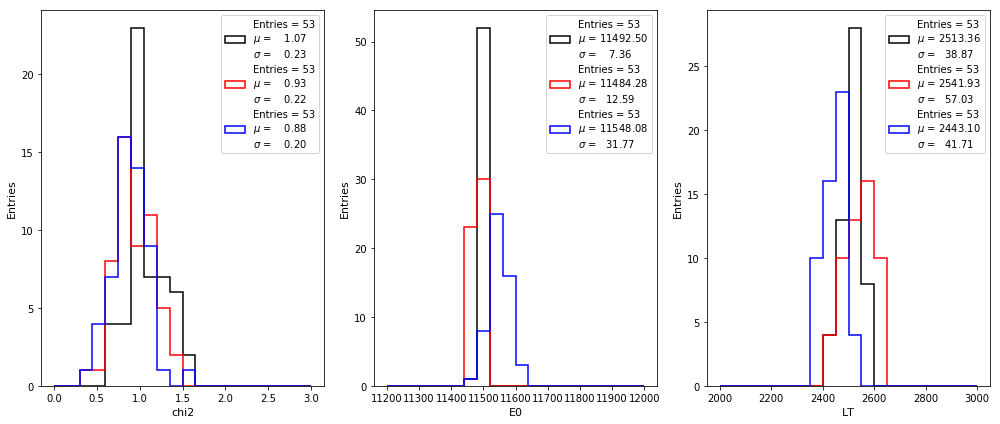

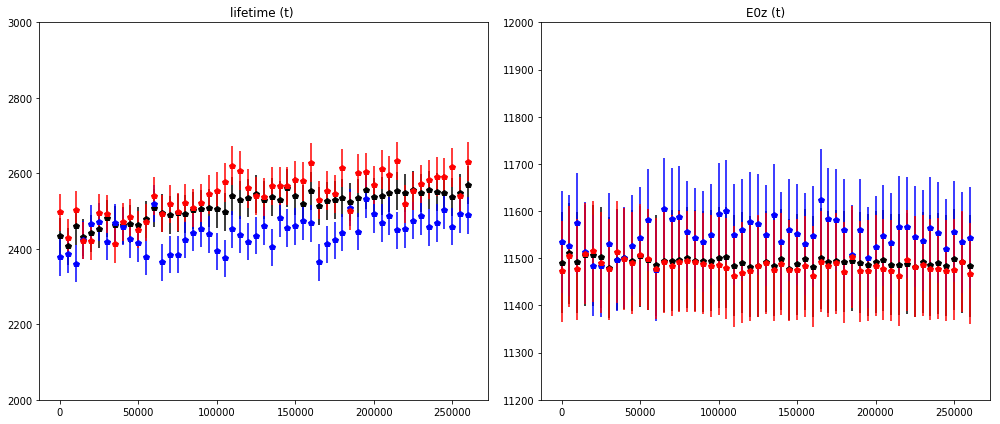

In [110]:
fbp = histo_fit_fb_pars(fp, fpf, fpb, range_e0 =(11200,12000))
plot_fit_fb_pars (fp, fpf, fpb,ltlim=(2000,3000), e0lim=(11200,12000))
print_fit_fb_pars(fbp)

#### E

In [111]:
fp, fpf, fpb = fb_fits(XT, DT, kcore, krNbins.Z, krNbins.S2e, 
                       range_z=(50,550), 
                       range_zf=(50,300), 
                       range_zb=(300,550), 
                       range_e = (7000, 12000),
                       energy = 'E', fit = FitType.profile)

chi2:  full  =     1.45  +-   0.29; front =     0.92 +-   0.19; back  =     0.98 +-   0.25;
e0  :  full  = 10071.33  +-   4.77; front = 10065.24 +-   6.10; back  = 10112.94 +-  16.05;
lt  :  full  =  2511.97  +-  39.90; front =  2538.41 +-  44.46; back  =  2450.28 +-  42.50;


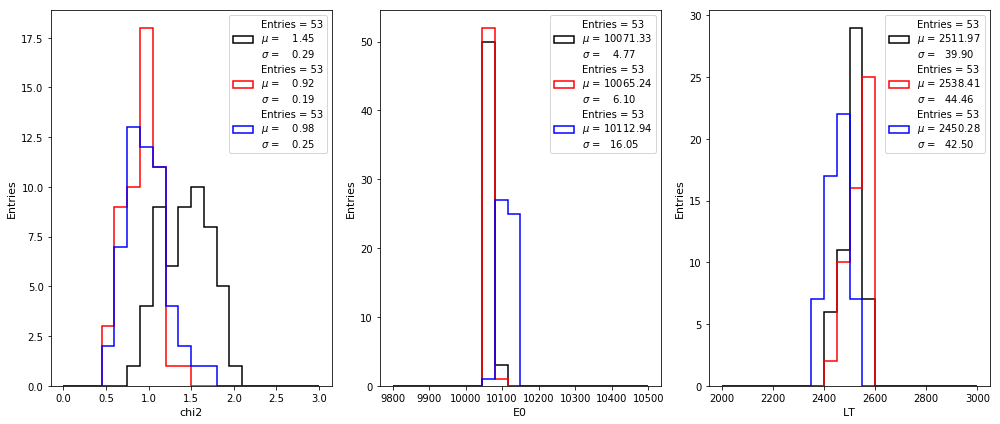

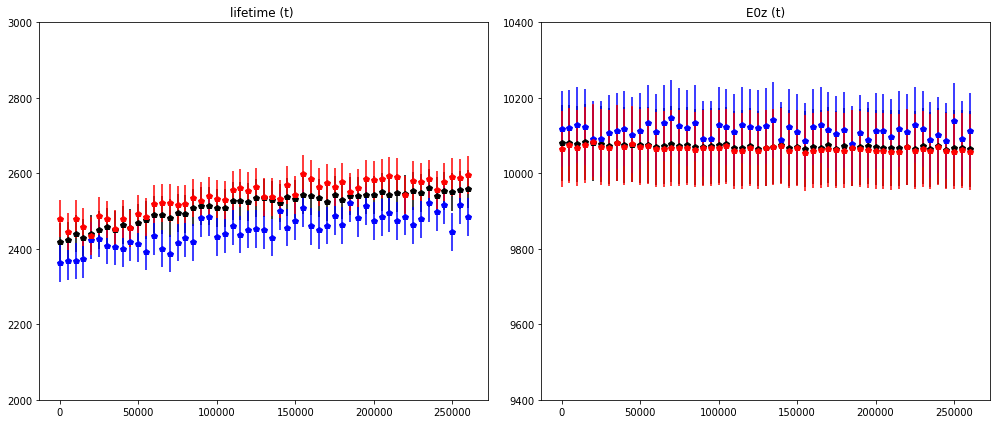

In [112]:
fbp = histo_fit_fb_pars(fp, fpf, fpb, range_e0 =(9800,10500))
plot_fit_fb_pars (fp, fpf, fpb,ltlim=(2000,3000), e0lim=(9400,10400))
print_fit_fb_pars(fbp)

#### Fits in core:

1. Using S2e chi2 of full fit is ~1, and thus no evidence of 2 LTs.
2. Using E, full fit chi2 is worse than f/b chi2s, showing either 2 LTs or a bias related with the normalization. Notice than E has been corrected by geometry but fits allow E0 to vary. 

### Fiducial

#### S2e

In [113]:
fp, fpf, fpb = fb_fits(XT, DT, kfid, krNbins.Z, krNbins.S2e, 
                       range_z=(50,550), 
                       range_zf=(50,300), 
                       range_zb=(300,550), 
                       range_e = (7000, 12000),
                       energy = 'S2e', fit = FitType.profile)

chi2:  full  =     1.12  +-   0.26; front =     1.07 +-   0.21; back  =     0.92 +-   0.21;
e0  :  full  = 11010.11  +-   8.47; front = 11010.21 +-  14.31; back  = 11067.56 +-  33.57;
lt  :  full  =  2439.76  +-  33.32; front =  2438.61 +-  57.28; back  =  2370.32 +-  39.36;


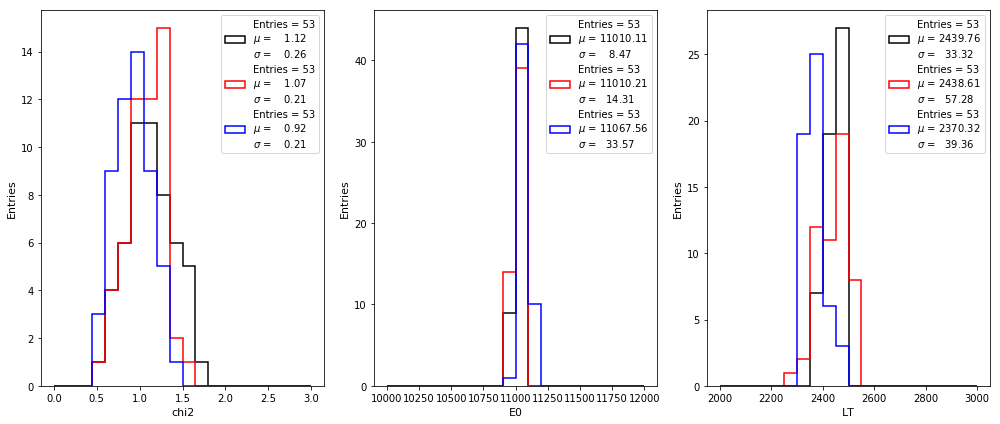

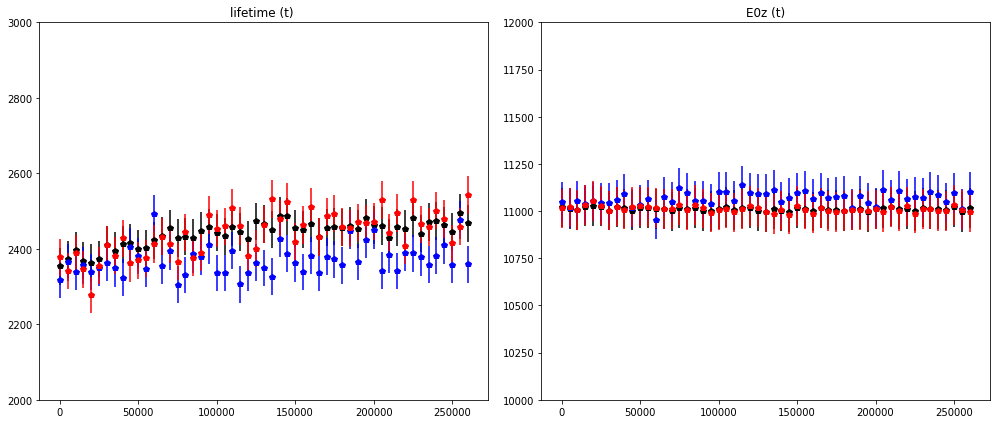

In [114]:
fbp = histo_fit_fb_pars(fp, fpf, fpb, range_e0 =(10000,12000))
plot_fit_fb_pars (fp, fpf, fpb,ltlim=(2000,3000), e0lim=(10000,12000))
print_fit_fb_pars(fbp)

#### E

In [115]:
fp, fpf, fpb = fb_fits(XT, DT, kfid, krNbins.Z, krNbins.S2e, 
                       range_z=(50,550), 
                       range_zf=(50,300), 
                       range_zb=(300,550), 
                       range_e = (7000, 12000),
                       energy = 'E', fit = FitType.profile)

chi2:  full  =     1.85  +-   0.35; front =     0.98 +-   0.24; back  =     1.04 +-   0.23;
e0  :  full  = 10070.58  +-   3.61; front = 10065.87 +-   4.85; back  = 10113.71 +-  10.78;
lt  :  full  =  2430.69  +-  32.28; front =  2451.26 +-  38.11; back  =  2370.31 +-  31.01;


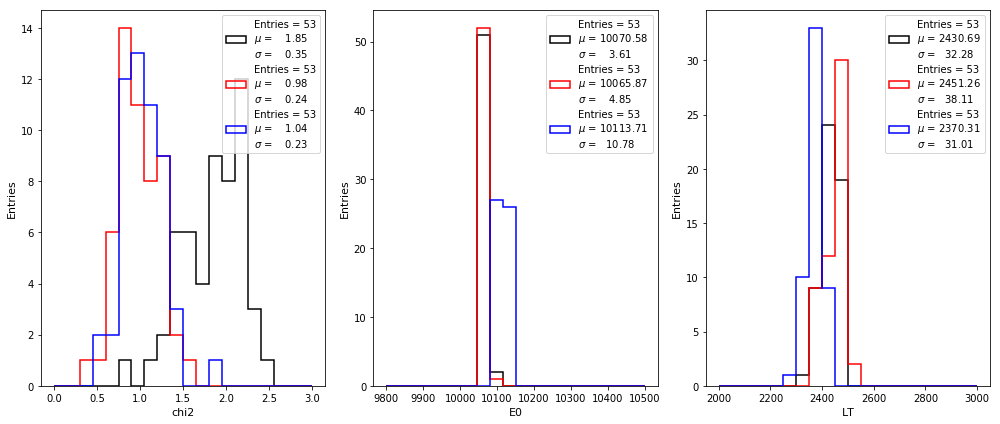

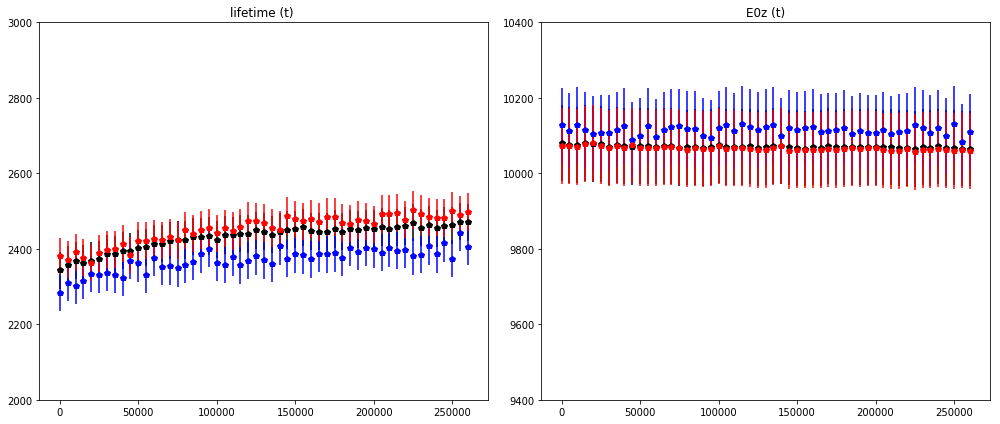

In [116]:
fbp = histo_fit_fb_pars(fp, fpf, fpb, range_e0 =(9800,10500))
plot_fit_fb_pars (fp, fpf, fpb,ltlim=(2000,3000), e0lim=(9400,10400))
print_fit_fb_pars(fbp)

#### Fits in fiducial:
1. S2e still compatible with a single LT
2. E fits to a single LT bad chi2, two apparent LT but also two apparent E0s, suggesting the possibility of a bias.

### Full

#### S2e

In [117]:
fp, fpf, fpb = fb_fits(XT, DT, kfull, krNbins.Z, krNbins.S2e, 
                       range_z=(50,550), 
                       range_zf=(50,300), 
                       range_zb=(300,550), 
                       range_e = (7000, 12000),
                       energy = 'S2e', fit = FitType.profile)

chi2:  full  =     1.21  +-   0.25; front =     1.21 +-   0.25; back  =     0.93 +-   0.20;
e0  :  full  = 10088.69  +-  10.20; front = 10109.59 +-  16.83; back  = 10127.06 +-  43.48;
lt  :  full  =  2684.17  +-  38.69; front =  2591.80 +-  67.06; back  =  2628.67 +-  74.24;


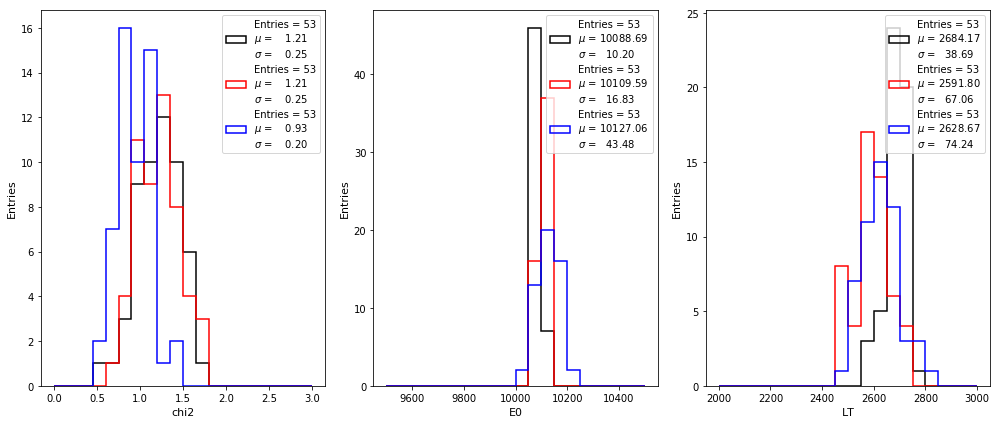

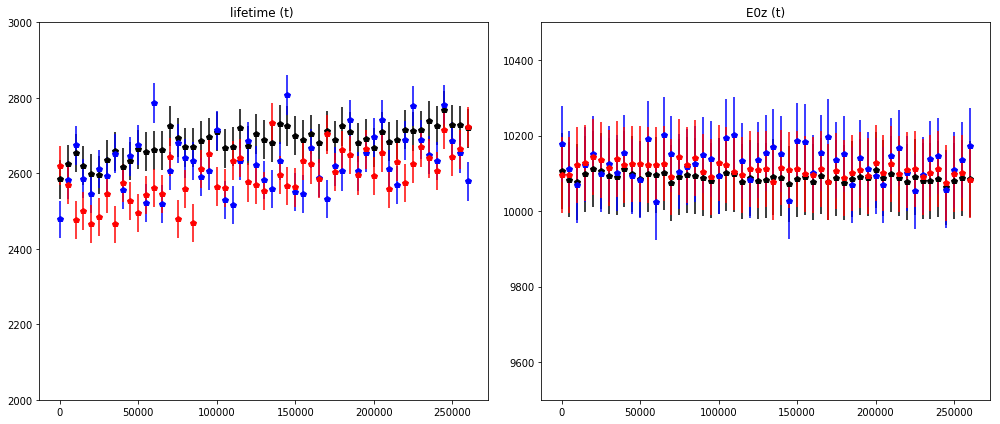

In [119]:
fbp = histo_fit_fb_pars(fp, fpf, fpb, range_e0 =(9500,10500))
plot_fit_fb_pars (fp, fpf, fpb,ltlim=(2000,3000), e0lim=(9500,10500))
print_fit_fb_pars(fbp)

#### E

In [120]:
fp, fpf, fpb = fb_fits(XT, DT, kfull, krNbins.Z, krNbins.S2e, 
                       range_z=(50,550), 
                       range_zf=(50,300), 
                       range_zb=(300,550), 
                       range_e = (7000, 12000),
                       energy = 'E', fit = FitType.profile)

chi2:  full  =     1.18  +-   0.25; front =     1.11 +-   0.26; back  =     1.00 +-   0.18;
e0  :  full  = 10057.95  +-   2.83; front = 10062.23 +-   3.64; back  = 10081.27 +-   9.58;
lt  :  full  =  2339.49  +-  27.60; front =  2327.68 +-  30.83; back  =  2309.31 +-  27.21;


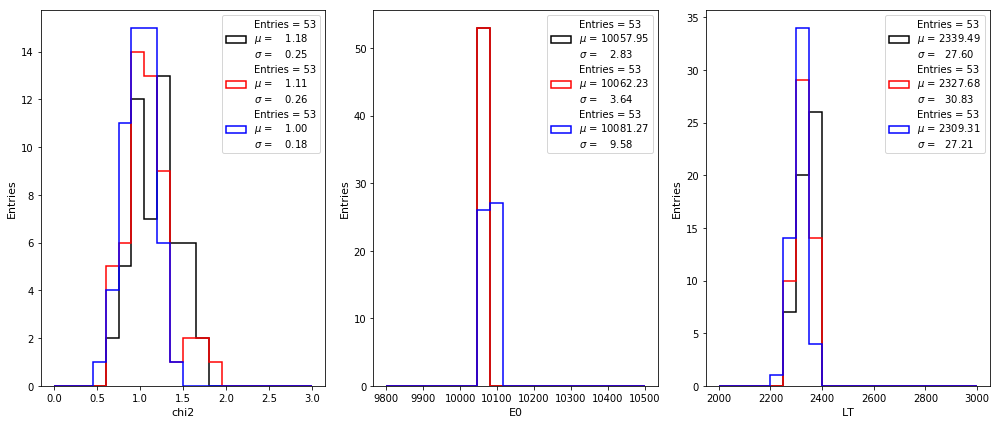

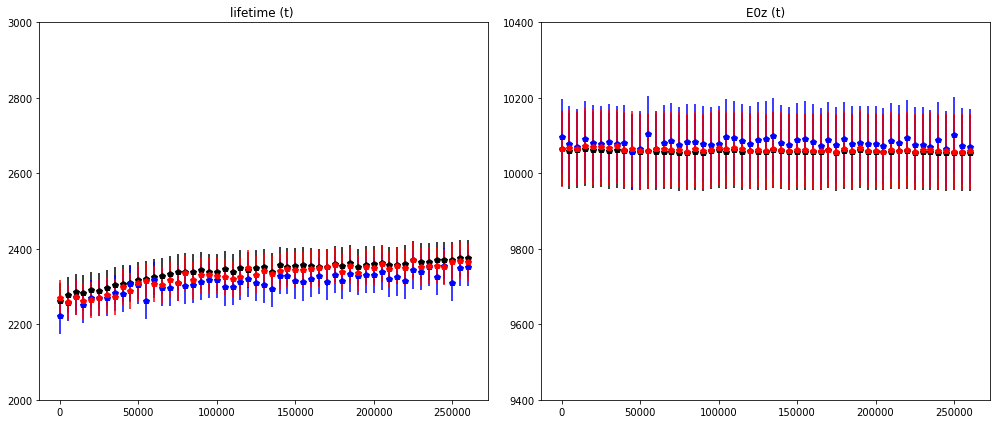

In [121]:
fbp = histo_fit_fb_pars(fp, fpf, fpb, range_e0 =(9800,10500))
plot_fit_fb_pars (fp, fpf, fpb,ltlim=(2000,3000), e0lim=(9400,10400))
print_fit_fb_pars(fbp)

#### Fits in full:
1. S2e trend is toward 2 LTs, although not convincing (chi2 values similar for full, f/b)
2. E in the full becomes more uniform and the evidence for 2 LTs dissappears. At the same time, the values of e0 for f/b become closer, **and the overall value of LT decreases significantly (by 300 mus) wrt S2e**. Why? 


### Do we have two LT?

1. The data does not appear to support 2 LT.
2. Fits to energy corrected (by geometry) can possibly bias the value of LT. **It seems necessary to fit S2e**.
3. Fits need to be divided in time bins, to take into account LT variation. 

## Fits in sectors

In [199]:
fps = fit_fcs_in_sectors(0, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)
                    

wedge = 0: chi2 =     0.92 +-   0.22; e0 = 11825.50 +-  17.09; lt =  2610.91 +-  62.07;


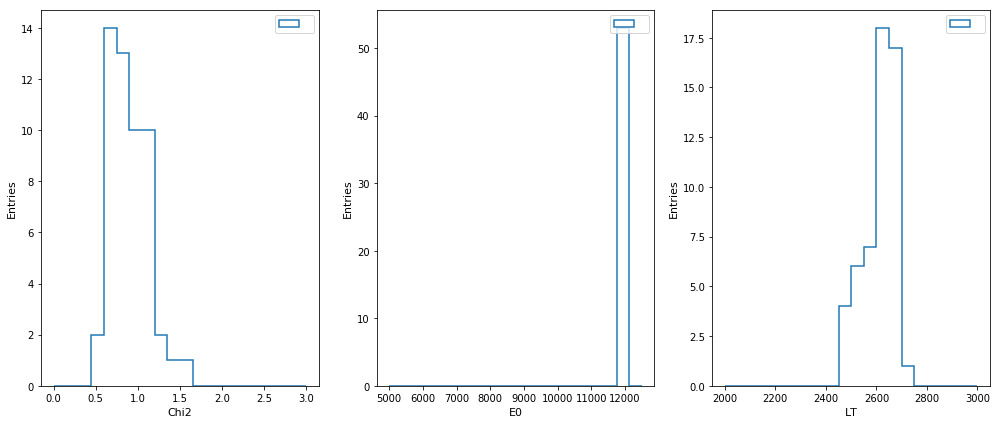

In [200]:
c2s, e0s, lts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(c2s, e0s, lts)

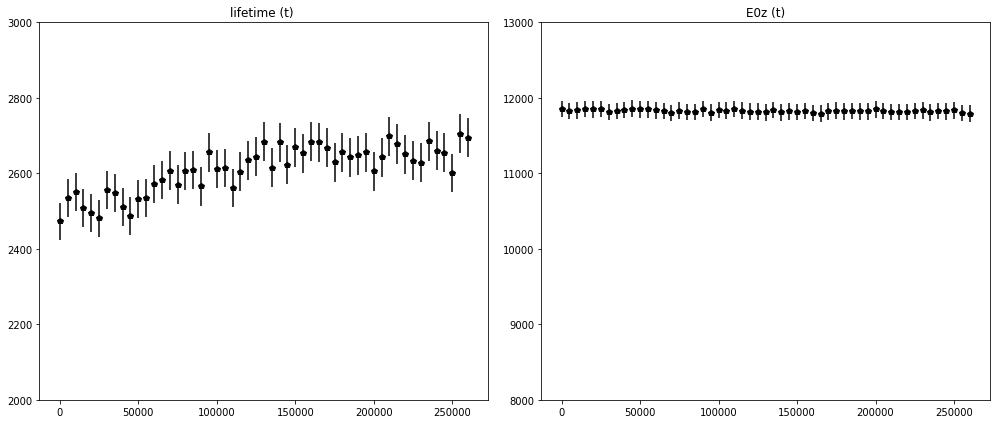

In [203]:
plot_fit_sectors(fps,  ltlim=(2000,3000), e0lim=(8000,13000))

In [204]:
fps = fit_fcs_in_sectors(1, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)
 

wedge = 0: chi2 =     0.97 +-   0.19; e0 = 11759.37 +-  20.10; lt =  2619.66 +-  66.74;
wedge = 1: chi2 =     0.94 +-   0.23; e0 = 11715.05 +-  14.93; lt =  2600.82 +-  50.24;


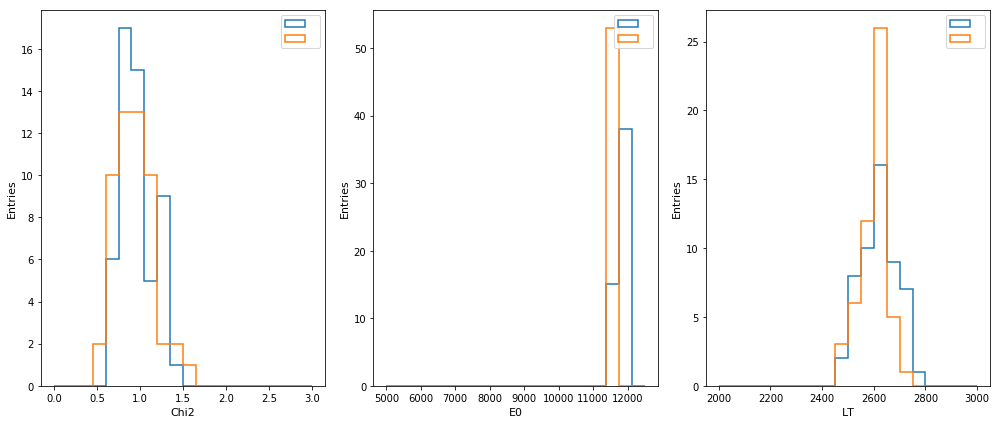

In [205]:
c2s, e0s, lts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(c2s, e0s, lts)

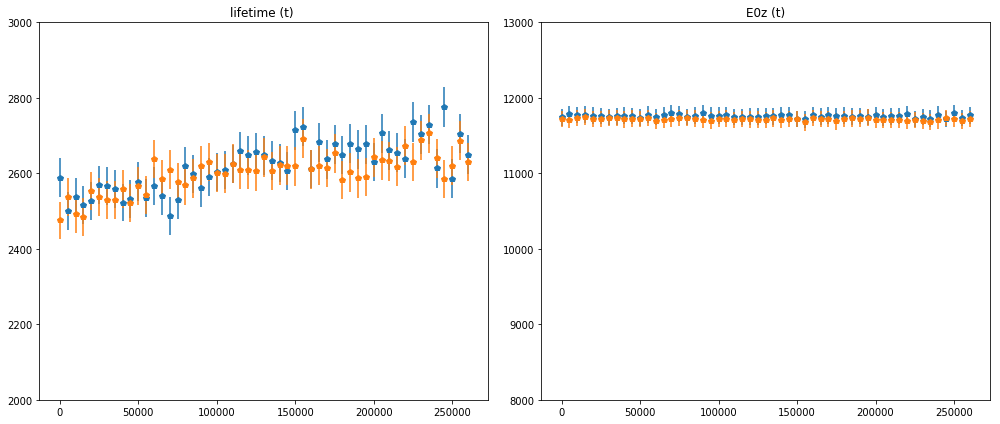

In [207]:
plot_fit_sectors(fps,  ltlim=(2000,3000), e0lim=(8000,13000))

In [208]:
fps = fit_fcs_in_sectors(2, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)



wedge = 0: chi2 =     0.90 +-   0.21; e0 = 12029.87 +-  21.21; lt =  2499.37 +-  54.95;
wedge = 1: chi2 =     0.99 +-   0.26; e0 = 11674.42 +-  13.97; lt =  2549.17 +-  52.35;
wedge = 2: chi2 =     0.96 +-   0.18; e0 = 11400.30 +-  14.63; lt =  2574.17 +-  43.86;
wedge = 3: chi2 =     0.97 +-   0.21; e0 = 11689.30 +-  13.02; lt =  2516.29 +-  42.36;


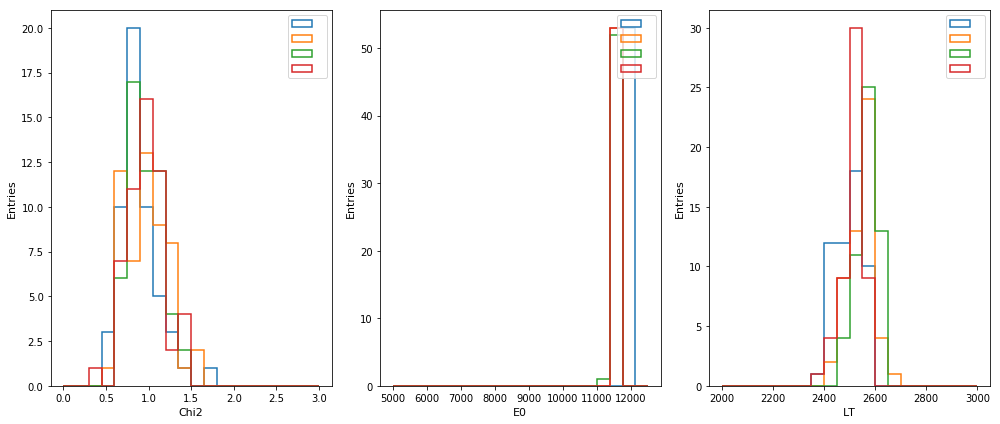

In [209]:
c2s, e0s, lts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(c2s, e0s, lts)

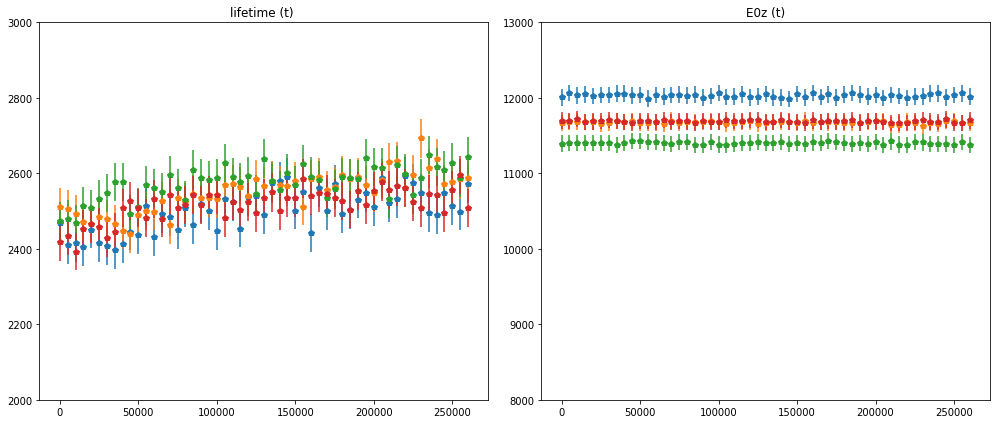

In [210]:
plot_fit_sectors(fps,  ltlim=(2000,3000), e0lim=(8000,13000))

In [211]:
fps = fit_fcs_in_sectors(3, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.90 +-   0.20; e0 = 12032.87 +-  16.74; lt =  2491.98 +-  45.51;
wedge = 1: chi2 =     0.90 +-   0.21; e0 = 11876.10 +-  24.82; lt =  2502.36 +-  55.86;
wedge = 2: chi2 =     1.00 +-   0.23; e0 = 11544.72 +-  16.12; lt =  2497.14 +-  44.33;
wedge = 3: chi2 =     0.98 +-   0.21; e0 = 11353.47 +-  21.19; lt =  2593.32 +-  69.83;
wedge = 4: chi2 =     0.95 +-   0.21; e0 = 11185.18 +-  16.51; lt =  2594.35 +-  49.73;
wedge = 5: chi2 =     0.93 +-   0.20; e0 = 11095.81 +-  16.74; lt =  2360.86 +-  43.87;
wedge = 6: chi2 =     0.96 +-   0.21; e0 = 11360.56 +-  18.37; lt =  2379.15 +-  52.22;
wedge = 7: chi2 =     0.94 +-   0.17; e0 = 11668.63 +-  18.66; lt =  2508.24 +-  55.69;


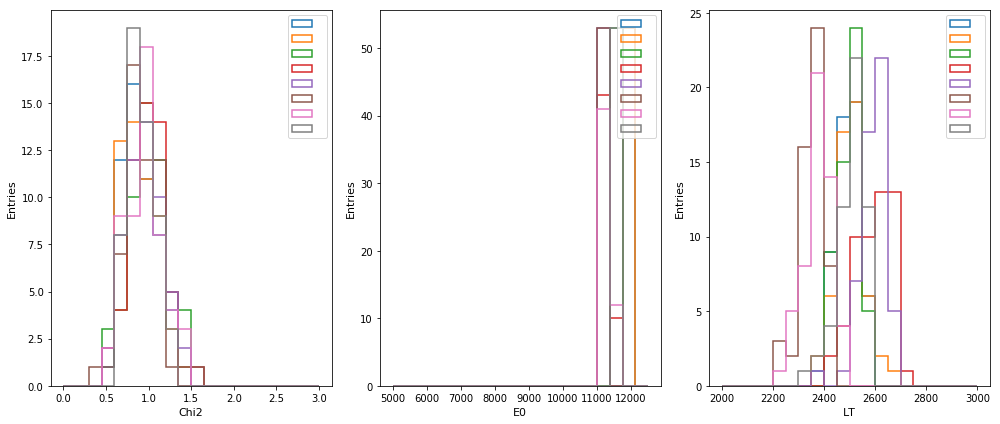

In [212]:
c2s, e0s, lts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(c2s, e0s, lts)

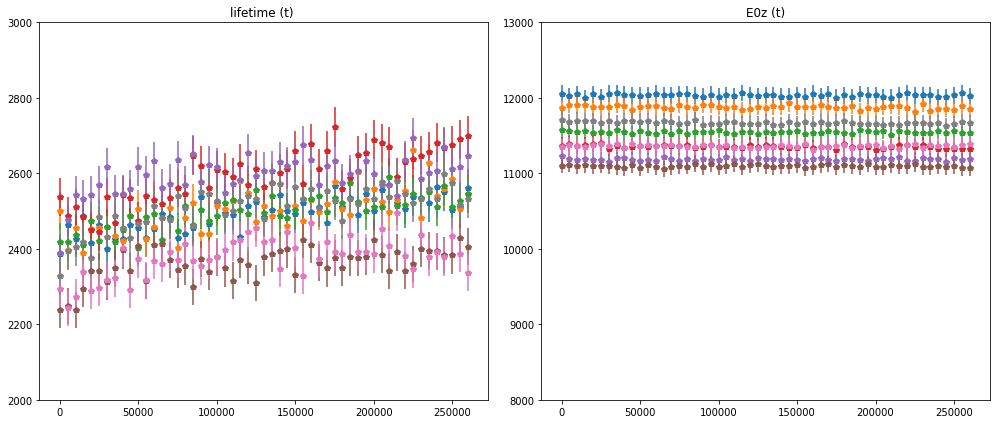

In [213]:
plot_fit_sectors(fps,  ltlim=(2000,3000), e0lim=(8000,13000))

In [214]:
fps = fit_fcs_in_sectors(4, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.92 +-   0.20; e0 = 11766.05 +-  16.91; lt =  2517.48 +-  50.93;
wedge = 1: chi2 =     0.94 +-   0.17; e0 = 11649.97 +-  13.43; lt =  2489.04 +-  38.29;
wedge = 2: chi2 =     0.93 +-   0.19; e0 = 11351.68 +-  17.30; lt =  2473.39 +-  42.67;
wedge = 3: chi2 =     0.91 +-   0.21; e0 = 11035.24 +-  14.85; lt =  2582.80 +-  62.46;
wedge = 4: chi2 =     0.95 +-   0.20; e0 = 10895.22 +-  17.00; lt =  2549.35 +-  48.44;
wedge = 5: chi2 =     0.97 +-   0.22; e0 = 10820.27 +-  15.81; lt =  2250.65 +-  36.55;
wedge = 6: chi2 =     1.02 +-   0.23; e0 = 11075.35 +-  18.60; lt =  2278.89 +-  45.23;
wedge = 7: chi2 =     0.90 +-   0.25; e0 = 11385.34 +-  18.51; lt =  2483.76 +-  44.10;


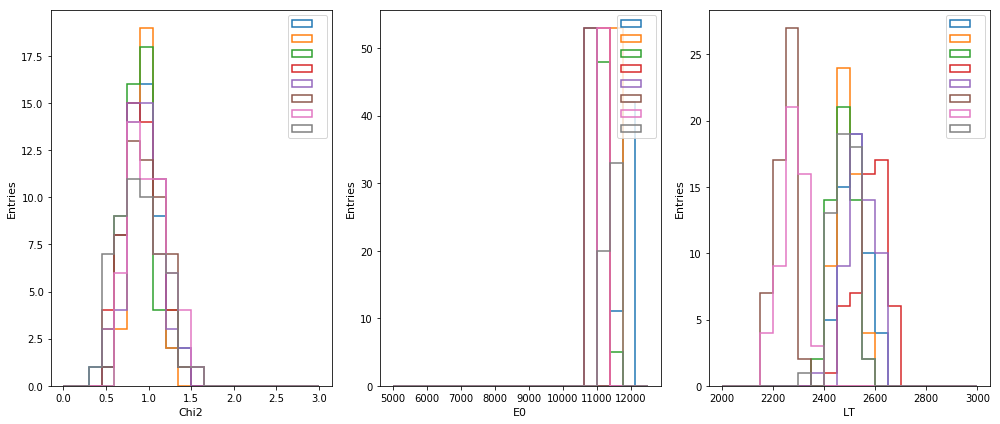

In [215]:
c2s, e0s, lts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(c2s, e0s, lts)

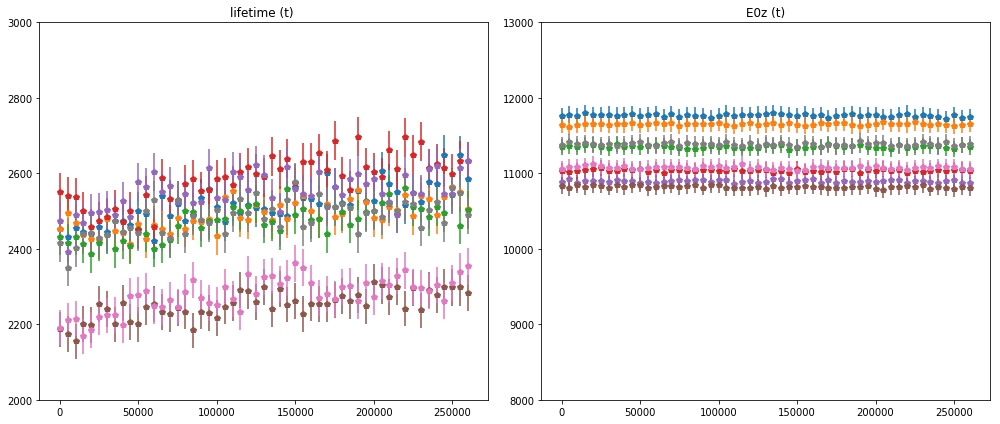

In [216]:
plot_fit_sectors(fps,  ltlim=(2000,3000), e0lim=(8000,13000))

In [217]:
fps = fit_fcs_in_sectors(5, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.87 +-   0.21; e0 = 11525.63 +-  16.46; lt =  2504.57 +-  40.90;
wedge = 1: chi2 =     0.95 +-   0.20; e0 = 11523.36 +-  14.71; lt =  2444.31 +-  35.95;
wedge = 2: chi2 =     0.92 +-   0.18; e0 = 11151.39 +-  16.61; lt =  2422.76 +-  40.93;
wedge = 3: chi2 =     0.97 +-   0.22; e0 = 10762.90 +-  15.59; lt =  2543.43 +-  64.62;
wedge = 4: chi2 =     0.98 +-   0.20; e0 = 10570.15 +-  17.51; lt =  2487.63 +-  44.91;
wedge = 5: chi2 =     0.93 +-   0.21; e0 = 10504.42 +-  14.51; lt =  2164.13 +-  26.96;
wedge = 6: chi2 =     0.98 +-   0.22; e0 = 10714.39 +-  16.73; lt =  2211.13 +-  35.07;
wedge = 7: chi2 =     0.96 +-   0.20; e0 = 10991.81 +-  19.30; lt =  2476.88 +-  48.35;


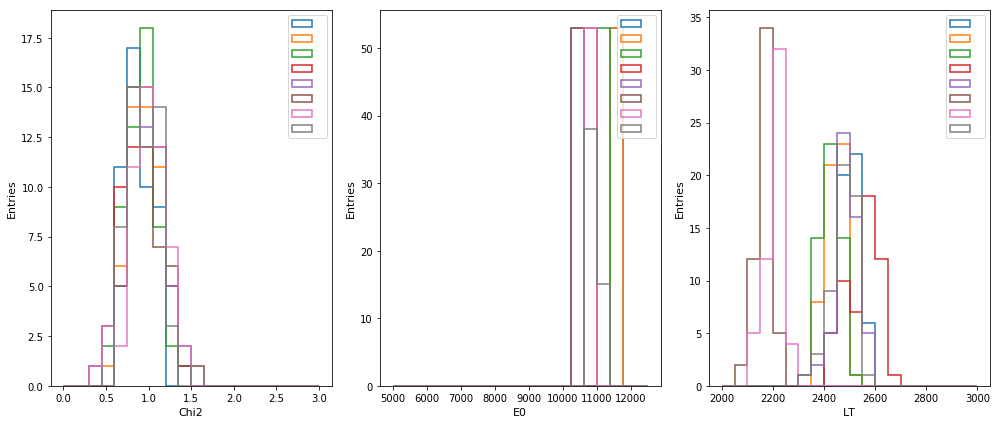

In [218]:
c2s, e0s, lts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(c2s, e0s, lts)

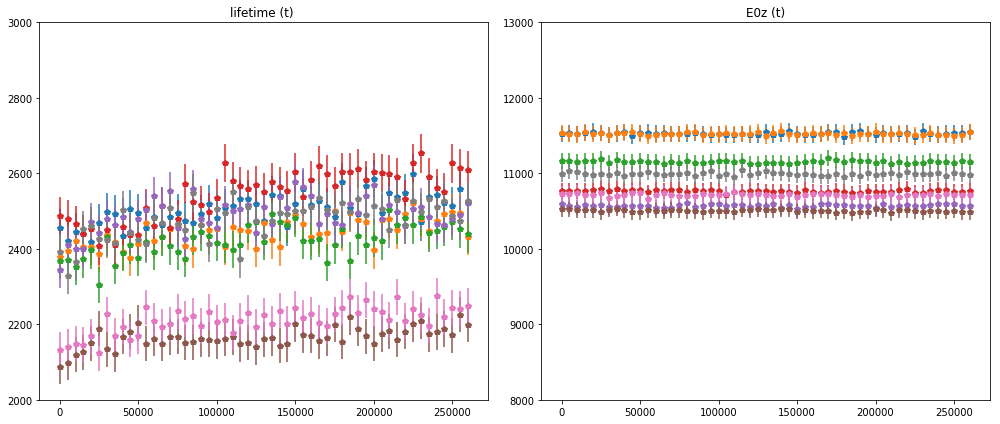

In [219]:
plot_fit_sectors(fps,  ltlim=(2000,3000), e0lim=(8000,13000))

In [220]:
fps = fit_fcs_in_sectors(6, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.87 +-   0.17; e0 = 11277.17 +-  14.33; lt =  2489.64 +-  34.74;
wedge = 1: chi2 =     0.99 +-   0.24; e0 = 11314.69 +-  14.37; lt =  2376.79 +-  28.72;
wedge = 2: chi2 =     0.99 +-   0.25; e0 = 10845.23 +-  17.05; lt =  2354.41 +-  32.86;
wedge = 3: chi2 =     0.92 +-   0.21; e0 = 10411.95 +-  13.09; lt =  2518.64 +-  51.11;
wedge = 4: chi2 =     0.94 +-   0.23; e0 = 10199.40 +-  16.65; lt =  2435.38 +-  42.74;
wedge = 5: chi2 =     0.92 +-   0.20; e0 =  9999.44 +-  16.48; lt =  2114.80 +-  32.95;
wedge = 6: chi2 =     0.91 +-   0.21; e0 = 10195.27 +-  21.01; lt =  2162.69 +-  39.82;
wedge = 7: chi2 =     0.94 +-   0.18; e0 = 10614.40 +-  14.99; lt =  2445.28 +-  46.97;


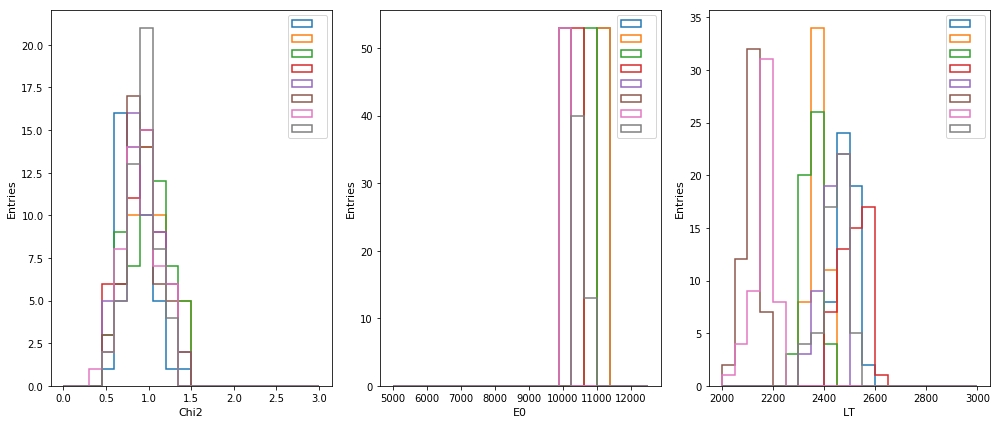

In [221]:
c2s, e0s, lts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(c2s, e0s, lts)

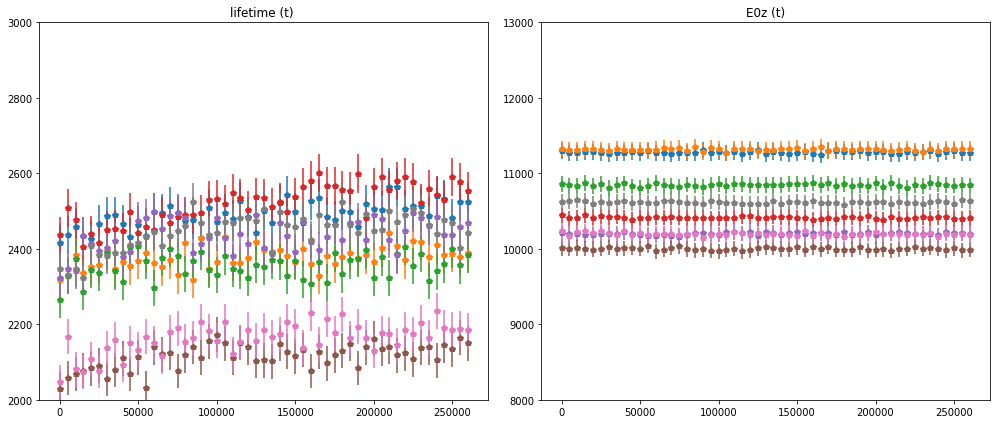

In [222]:
plot_fit_sectors(fps,  ltlim=(2000,3000), e0lim=(8000,13000))

In [223]:
fps = fit_fcs_in_sectors(7, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (5000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.95 +-   0.22; e0 = 10875.80 +-  18.40; lt =  2465.42 +-  41.42;
wedge = 1: chi2 =     1.01 +-   0.18; e0 = 10870.20 +-  13.67; lt =  2348.77 +-  25.95;
wedge = 2: chi2 =     0.92 +-   0.24; e0 = 10308.45 +-  16.70; lt =  2314.97 +-  28.08;
wedge = 3: chi2 =     0.97 +-   0.27; e0 =  9925.53 +-  18.27; lt =  2473.53 +-  61.91;
wedge = 4: chi2 =     0.94 +-   0.25; e0 =  9687.73 +-  18.11; lt =  2403.01 +-  41.65;
wedge = 5: chi2 =     0.89 +-   0.20; e0 =  9322.76 +-  17.07; lt =  2045.59 +-  22.87;
wedge = 6: chi2 =     0.90 +-   0.17; e0 =  9555.69 +-  18.52; lt =  2073.01 +-  32.49;
wedge = 7: chi2 =     0.99 +-   0.19; e0 = 10149.95 +-  17.81; lt =  2412.40 +-  45.07;


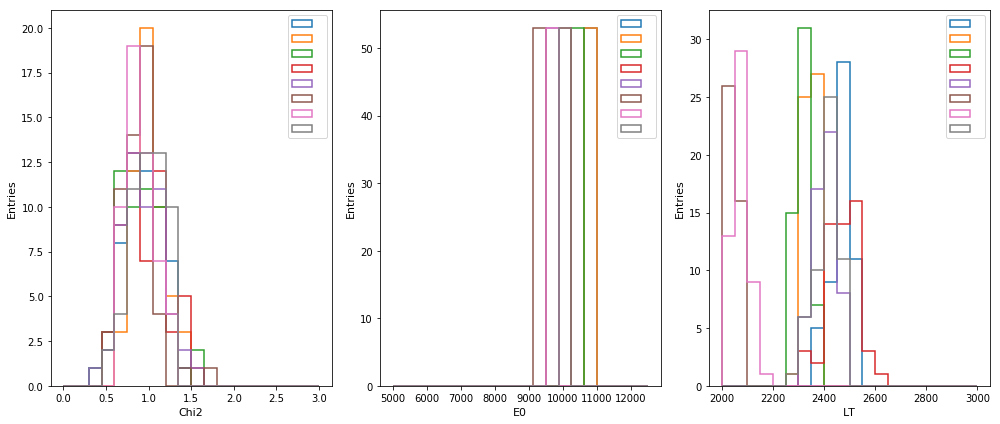

In [224]:
c2s, e0s, lts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(c2s, e0s, lts)

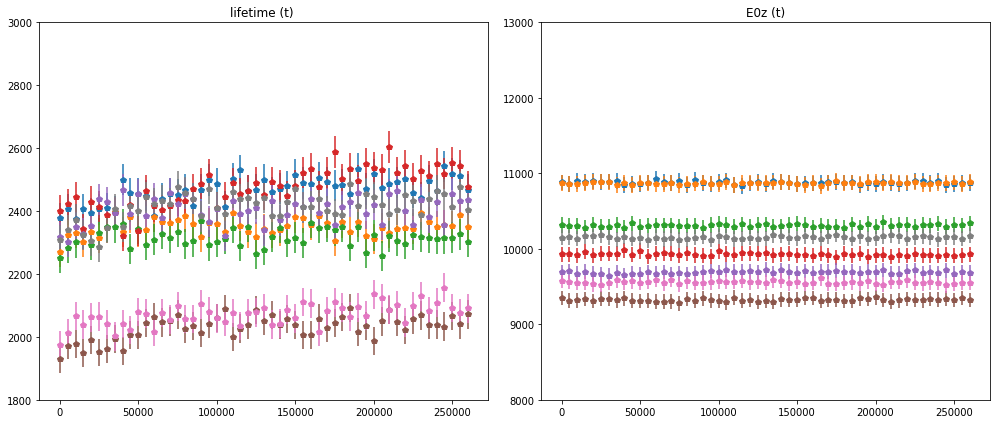

In [226]:
plot_fit_sectors(fps,  ltlim=(1800,3000), e0lim=(8000,13000))

In [227]:
fps = fit_fcs_in_sectors(8, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (5000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.83 +-   0.19; e0 = 10227.13 +-  17.25; lt =  2404.86 +-  41.35;
wedge = 1: chi2 =     0.88 +-   0.19; e0 = 10215.29 +-  14.81; lt =  2278.74 +-  31.40;
wedge = 2: chi2 =     0.86 +-   0.21; e0 =  9583.25 +-  16.75; lt =  2257.94 +-  34.32;
wedge = 3: chi2 =     0.90 +-   0.21; e0 =  9220.39 +-  14.05; lt =  2404.50 +-  52.76;
wedge = 4: chi2 =     1.01 +-   0.22; e0 =  9013.96 +-  21.29; lt =  2304.08 +-  41.79;
wedge = 5: chi2 =     0.97 +-   0.19; e0 =  8482.45 +-  18.28; lt =  2010.75 +-   4.56;
wedge = 6: chi2 =     0.92 +-   0.18; e0 =  8766.80 +-  23.55; lt =  2014.04 +-   5.09;
wedge = 7: chi2 =     0.94 +-   0.24; e0 =  9496.21 +-  23.36; lt =  2301.10 +-  41.12;


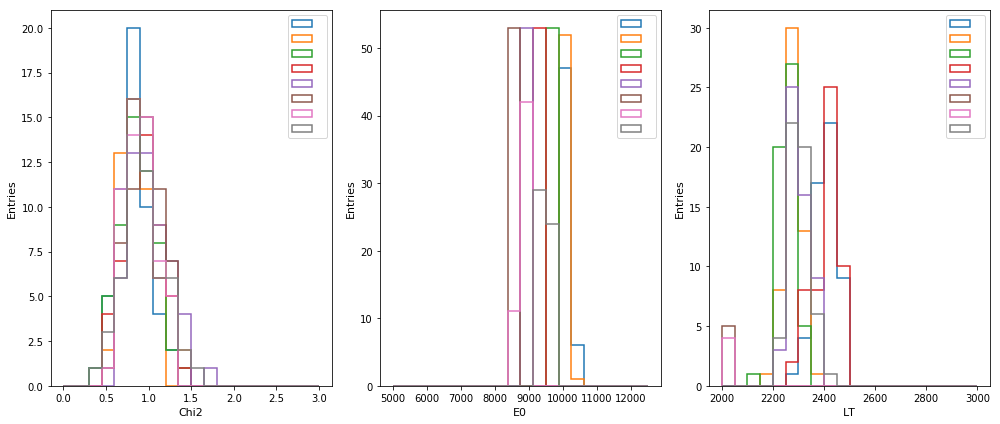

In [228]:
c2s, e0s, lts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(c2s, e0s, lts)

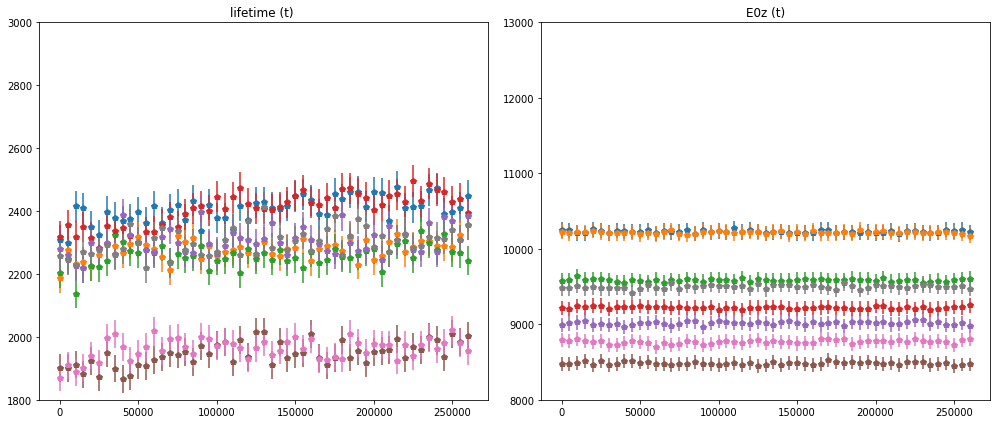

In [230]:
plot_fit_sectors(fps,  ltlim=(1800,3000), e0lim=(8000,13000))

In [231]:
fps = fit_fcs_in_sectors(9, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (5000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.88 +-   0.23; e0 =  8941.96 +-  39.24; lt =  2492.27 +-  85.49;
wedge = 1: chi2 =     0.95 +-   0.25; e0 =  8831.03 +-  39.28; lt =  2535.57 +-  87.26;
wedge = 2: chi2 =     0.89 +-   0.22; e0 =  8306.26 +-  34.73; lt =  2428.86 +-  87.41;
wedge = 3: chi2 =     0.91 +-   0.21; e0 =  8032.42 +-  28.22; lt =  2436.00 +-  71.48;
wedge = 4: chi2 =     0.91 +-   0.21; e0 =  7747.31 +-  28.83; lt =  2551.10 +-  73.53;
wedge = 5: chi2 =     0.94 +-   0.23; e0 =  7185.96 +-  32.49; lt =  2329.85 +-  80.59;
wedge = 6: chi2 =     0.91 +-   0.19; e0 =  7397.41 +-  31.38; lt =  2462.29 +-  83.99;
wedge = 7: chi2 =     0.93 +-   0.23; e0 =  8174.29 +-  41.08; lt =  2719.25 +- 100.32;


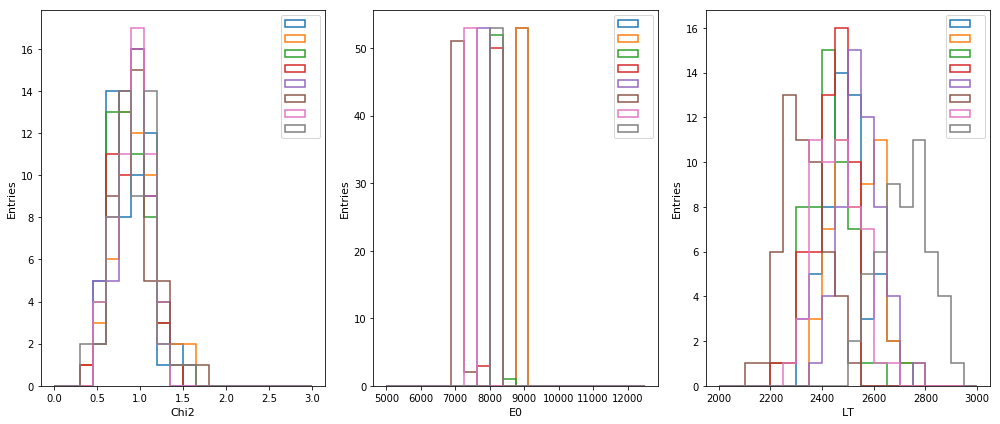

In [232]:
c2s, e0s, lts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(c2s, e0s, lts)

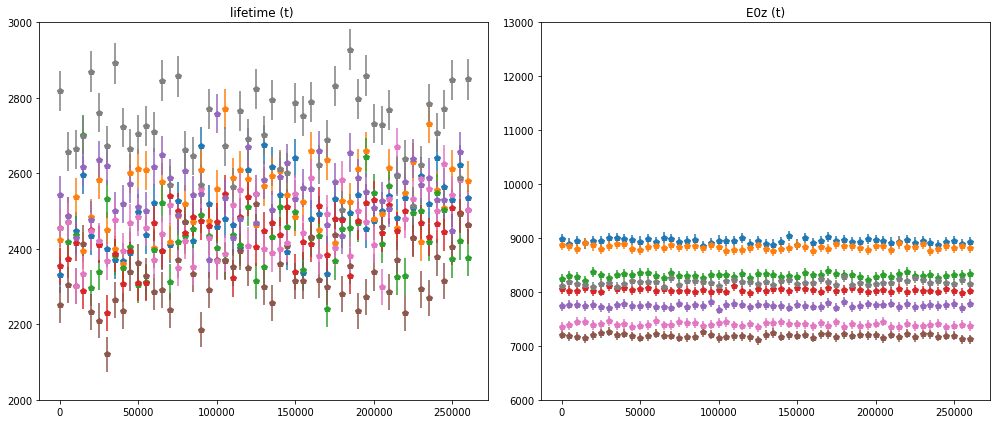

In [235]:
plot_fit_sectors(fps,  ltlim=(2000,3000), e0lim=(6000,13000))

### Fits in sectors:
1. chi2 of fits is good.
2. E0 decreases in each sector and varies significantly with phi.
3. LT has an structure, splitting in some sectors in two peaks.

## Maps

In [280]:
ts, tSM, aSM = lt_maps(XT, DT, KRES, 
                   krNbins.Z, krNbins.S2e,
                   range_z     = (50,550),
                   range_e     = (5000, 13000),
                   range_chi2  = (0,3),
                   range_lt    = (1800, 3000),
                   energy      = 'S2e', 
                   fit         = FitType.profile,
                   nsectors    = 10,
                   verbose     = True)

Fitting sector 0
 number of wedges in sector 1
Fitting sector 1
 number of wedges in sector 2
Fitting sector 2
 number of wedges in sector 4
Fitting sector 3
 number of wedges in sector 8
Fitting sector 4
 number of wedges in sector 8
Fitting sector 5
 number of wedges in sector 8
Fitting sector 6
 number of wedges in sector 8
Fitting sector 7
 number of wedges in sector 8
Fitting sector 8
 number of wedges in sector 8
Fitting sector 9
 number of wedges in sector 8


In [284]:
ts[1]

5000

LT min = 1945.7174113235462, LT max = 2719.2544966895143


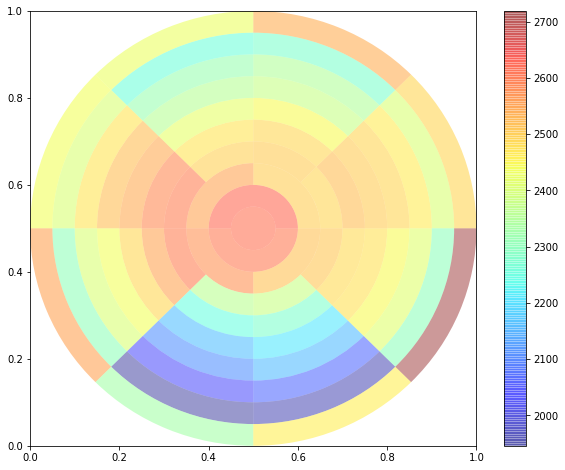

In [270]:
draw_map(W, aSM, wmap = MapType.LT, figsize=(10,8))

LT min = 7185.95629665779, LT max = 12032.865867264994


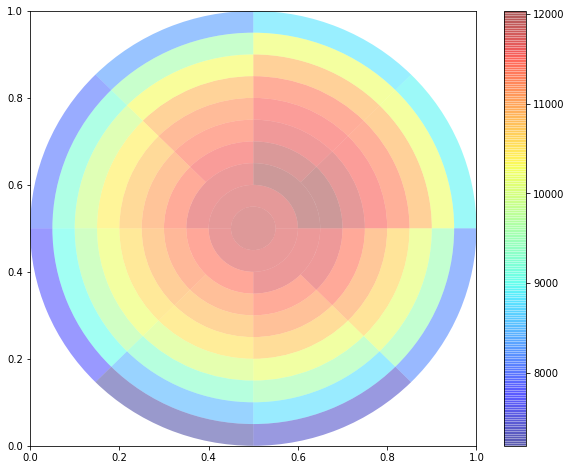

In [271]:
draw_map(W, aSM, wmap = MapType.E0, figsize=(10,8))

LT min = 13.020100180976549, LT max = 41.07909694558728


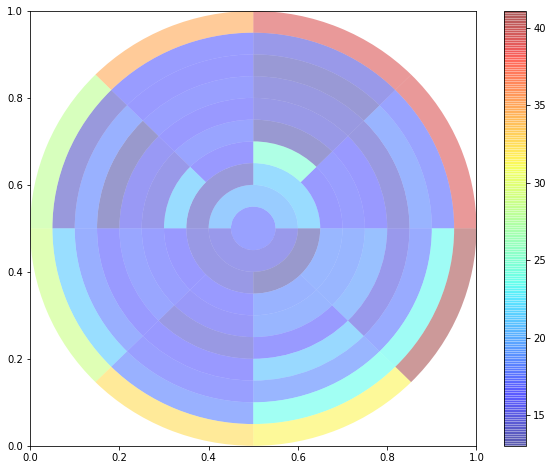

In [274]:
draw_map(W, aSM, wmap = MapType.E0u, figsize=(10,8))

LT min = 25.946299429608956, LT max = 100.32000508635365


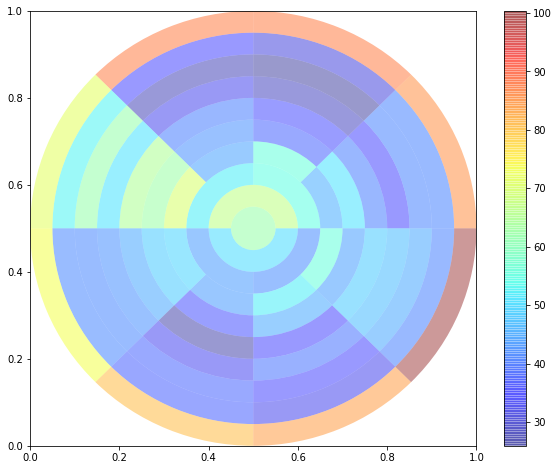

In [275]:
draw_map(W, aSM, wmap = MapType.LTu, figsize=(10,8))

LT min = 0.166085092626691, LT max = 0.26545421993513607


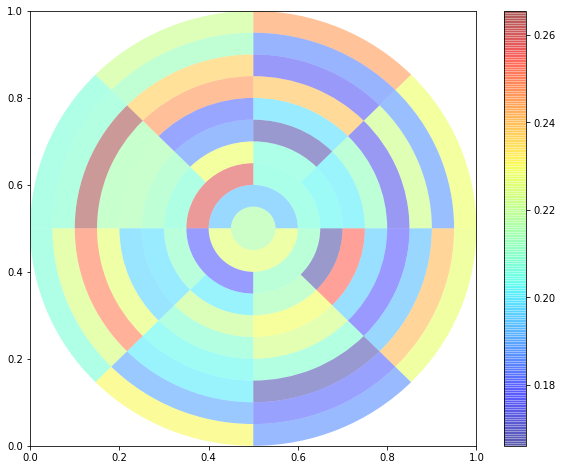

In [285]:
draw_map(W, aSM, wmap = MapType.chi2, figsize=(10,8))

In [287]:
draw_map_time_slice(W, tSM, tslice = 0, wmap = MapType.lt, 
                    verbose = True,figsize=(10,8))

AttributeError: lt

### Fit in four quadrants

xlim = (-125, -75), ylim =(-125, -75)
xlim = (-125, -75), ylim =(75, 125)
xlim = (75, 125), ylim =(75, 125)
xlim = (75, 125), ylim =(-125, -75)
 E (z=0) = 11101.01306529403 +-9.977304179625452 
 LT      = -2685.6861454916398 +-17.653192653441632 
 chi2    = 1.66777660476386 
 E (z=0) = 10184.69045457425 +-10.404188223847344 
 LT      = -2419.628144410357 +-16.715088329522928 
 chi2    = 1.8448213159379219 
 E (z=0) = 9885.837724374736 +-9.359567769628175 
 LT      = -2312.144042372873 +-14.60486893543107 
 chi2    = 1.33113660480815 
 E (z=0) = 10303.885308334357 +-8.8681086220466 
 LT      = -2570.1911651476807 +-16.51927986234456 
 chi2    = 0.923590222925289 


[None, None, None, None]

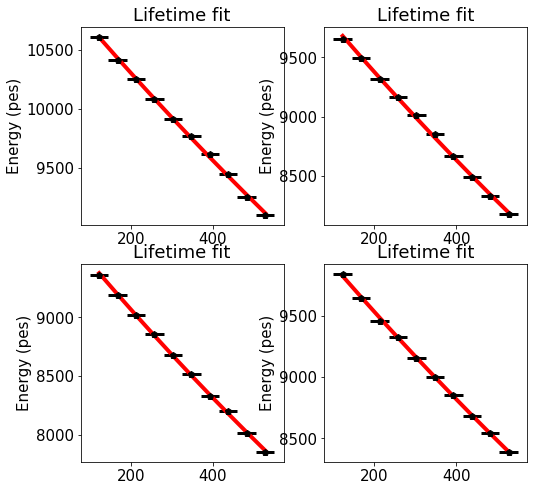

In [38]:
KF = krf.lifetimes_in_XYRange(kdst.fid, krNBins, krBins, krRanges, xyr,
                         XL = [(-125, -75), (-125, -75), (75, 125),(75, 125)],
                         YL = [(-125, -75), (75, 125), (75, 125),(-125, -75)],
                         figsize=(8,8))
[krf.print_fit(kf) for kf in KF ]

### Fit upper half and lower half

xlim = (-180, 180), ylim =(0, 180)
xlim = (-180, 180), ylim =(-180, 0)
 E (z=0) = 10576.481130783859 +-2.891784215694205 
 LT      = -2589.689290035225 +-5.356465287097921 
 chi2    = 2.696865606966407 
 E (z=0) = 11114.004025581817 +-2.6563862975092887 
 LT      = -2712.9468212402444 +-4.9619935208116965 
 chi2    = 4.269302239874724 


[None, None]

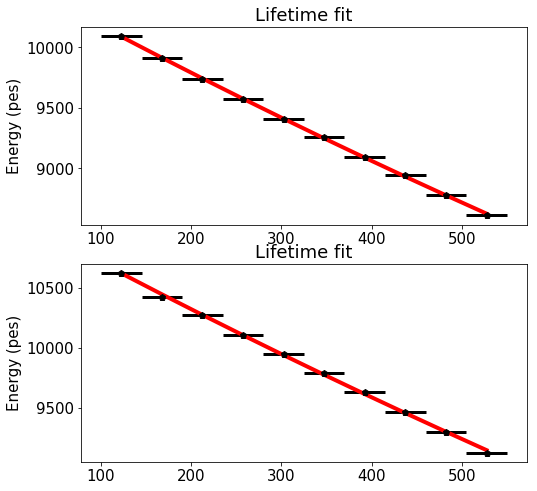

In [39]:
KF = krf.lifetimes_in_XYRange(kdst.fid, krNBins, krBins, krRanges, xyr,
                         XL = [(-180, 180), (-180, 180)],
                         YL = [(0, 180), (-180, 0)],
                         nx = 2, ny = 1, 
                         figsize=(8,8))
[krf.print_fit(kf) for kf in KF ]

In [40]:
es_low = KF[0].par[0]
esu_low = KF[0].err[0]
es_hig = KF[1].par[0]
esu_hig = KF[1].err[0]
lt_low = np.abs(KF[0].par[1])
ltu_low = np.abs(KF[0].err[1])
lt_hig = np.abs(KF[1].par[1])
ltu_hig = np.abs(KF[1].err[1])
print(f"LOW:  es +- err = {es_low} +- {esu_low}")
print(f"High:  es +- err = {es_hig} +- {esu_hig}")
print(f"LOW:  lt +- err = {lt_low} +- {ltu_low}")
print(f"High:  lt +- err = {lt_hig} +- {ltu_hig}")

LOW:  es +- err = 10576.481130783859 +- 2.891784215694205
High:  es +- err = 11114.004025581817 +- 2.6563862975092887
LOW:  lt +- err = 2589.689290035225 +- 5.356465287097921
High:  lt +- err = 2712.9468212402444 +- 4.9619935208116965


### Time profile of LT in the fiducial

In [41]:
fits = krf.lifetimes_in_TRange(kdst.fid, krNBins, krBins, krRanges,  TL=krTimes.TL)

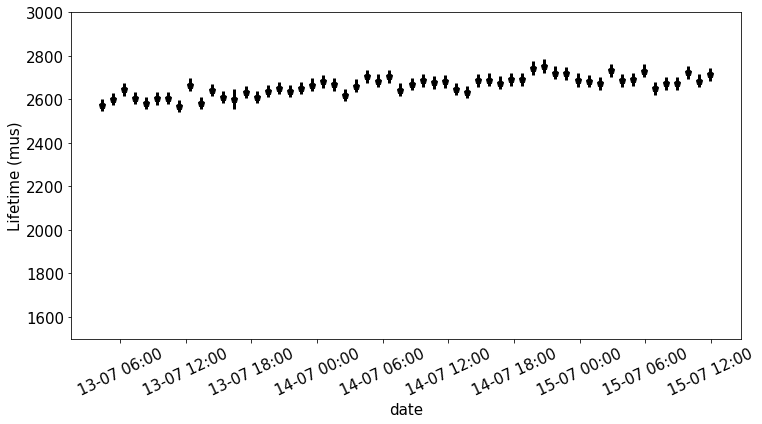

In [42]:
krp.plot_lifetime_T(fits, krTimes.timeStamps, ltlim=(1500, 3000),  figsize=(12,6))

### Time profile of LT in hard core

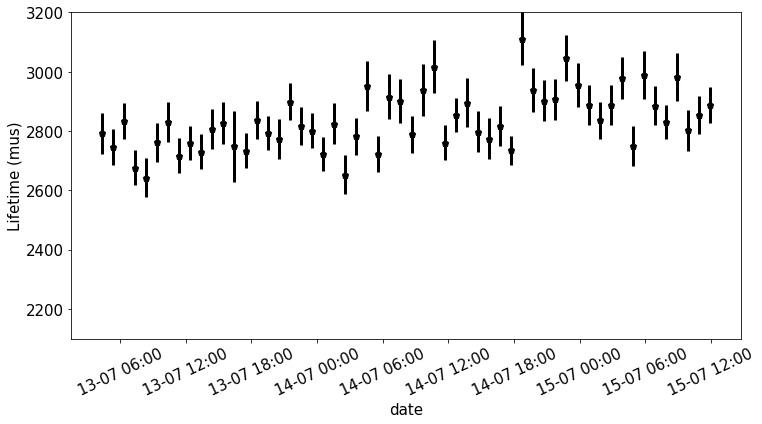

In [50]:
fits = krf.lifetimes_in_TRange(kdst.hcore, krNBins, krBins, krRanges,  TL=krTimes.TL)
krp.plot_lifetime_T(fits, krTimes.timeStamps,ltlim=(2100, 3200),  figsize=(12,6))

### Time profile in lower region

In [45]:
klow = krc.select_region_XY(dst, (-150,150), (-180,-100))

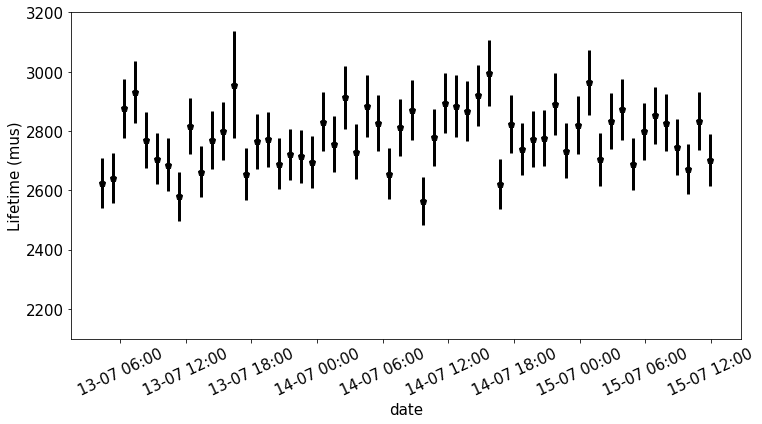

In [51]:
fits = krf.lifetimes_in_TRange(klow, krNBins, krBins, krRanges,  TL=krTimes.TL)
krp.plot_lifetime_T(fits, krTimes.timeStamps,ltlim=(2100, 3200),  figsize=(12,6))

### Time profile in upper region

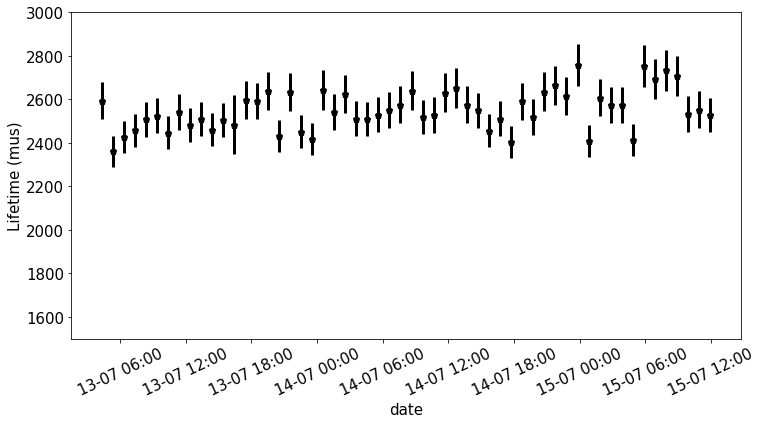

In [52]:
klow = krc.select_region_XY(dst, (-150, 150), (100, 180))
fits = krf.lifetimes_in_TRange(klow, krNBins, krBins, krRanges,  TL=krTimes.TL)
krp.plot_lifetime_T(fits, krTimes.timeStamps,ltlim=(1500, 3000),  figsize=(12,6))

### Compute lifetime maps

In [53]:
krfs = krf.fit_lifetime_slices(kdst.full, krNBins, krBins, krRanges, fit_var = "E", min_entries=100)

/Users/jjgomezcadenas/Projects/IC/invisible_cities/core/fit_functions.py:135: RuntimeWarning: invalid value encountered in less_equal
  if np.any(sigma_r <= 0):
/Users/jjgomezcadenas/miniconda/envs/IC3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [54]:
Escale_abs, ELT_abs, Echi2, valid = krfs.Es, krfs.LT, krfs.chi2, krfs.valid  
Escale     = to_relative(Escale_abs, percentual=True)  # errors in %
ELT        = to_relative(ELT_abs, percentual=True)

In [55]:
valid.shape

(60, 60)

In [56]:
np.count_nonzero(valid) / (valid.shape[0] * valid.shape[1])

0.7905555555555556

In [57]:
El = KrMeanAndStd(mu    = np.nanmean(ELT      .value      [valid]),
                  std   = np.nanstd (ELT      .value      [valid]),
                  mu_u  = np.nanmean(ELT      .uncertainty[valid]),
                  std_u = np.nanstd (ELT      .uncertainty[valid]))
Es = KrMeanAndStd(mu    = np.nanmean(Escale   .value      [valid]),
                  std   = np.nanstd (Escale   .value      [valid]),
                  mu_u  = np.nanmean(Escale   .uncertainty[valid]),
                  std_u = np.nanstd (Escale   .uncertainty[valid]))

print(f'Lifetime value           : mu +- std ={El.mu} +- {El.std}')
print(f'Lifetime uncertainty     : mu +- std ={El.mu_u} +- {El.std_u}')
print(f'Energy scale value       : mu +- std ={Es.mu} +- {Es.std}')
print(f'Energy scale uncertainty : mu +- std ={Es.mu_u} +- {Es.std_u}')

Lifetime value           : mu +- std =2388.941296419824 +- 509.6427868292293
Lifetime uncertainty     : mu +- std =4.036384934005207 +- 1.952514852007325
Energy scale value       : mu +- std =9968.426744797545 +- 1348.947472763714
Energy scale uncertainty : mu +- std =0.623565503072777 +- 0.36573556363474935


In [58]:
n_sigma  = 2.5
u_sigma  = 2.5
kltl = KrLTLimits(Es  = minmax(Es.mu - n_sigma * Es.std, Es.mu + n_sigma * Es.std),
                  LT  = minmax(El.mu - n_sigma * El.std,El.mu + n_sigma * El.std),
                  Eu  = minmax(max(Es.mu_u - u_sigma * Es.std_u, 1e-3),  
                              Es.mu_u + u_sigma * Es.std_u),
                  LTu = minmax(max(El.mu_u - u_sigma * El.std_u, 1e-3),
                              El.mu_u + u_sigma * El.std_u))
 


print(f" Energy scale (E): E_min = {kltl.Es.min}; E_max = {kltl.Es.max}")
print(f" Lifetime (ELT): ELT_min = {kltl.LT.min}; ELT_max = {kltl.LT.max}")
print(f" Energy scale error (Eu): Eu_min = {kltl.Eu.min}; Eu_max = {kltl.Eu.max}")
print(f" Lifetime error (ELTu): ELTu_min = {kltl.LTu.min}; ELTu_max = {kltl.LTu.max}")

 Energy scale (E): E_min = 6596.058062888261; E_max = 13340.79542670683
 Lifetime (ELT): ELT_min = 1114.8343293467508; ELT_max = 3663.0482634928976
 Energy scale error (Eu): Eu_min = 0.001; Eu_max = 1.5379044121596506
 Lifetime error (ELTu): ELTu_min = 0.001; ELTu_max = 8.91767206402352


### Map display

In [59]:
invalid = ~valid
mask = valid

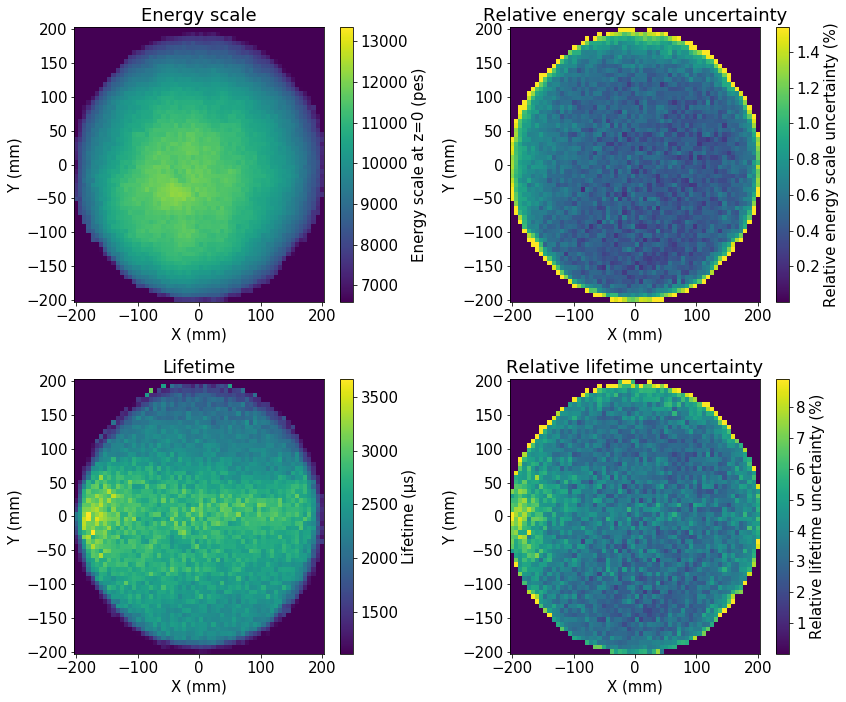

In [60]:
krp.figsize("L")
krp.display_lifetime_maps(Escale, ELT, kltl, krBins.cXY, cmap="viridis", mask=valid)
                         

(1.2341219470183695, 0.66563217860108326)

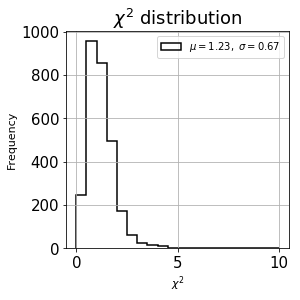

In [61]:
krp.figsize("S")
krh.h1d(Echi2[valid], bins=20, range=(0,10), xlabel="$\chi^2$", ylabel='Frequency',
        title="$\chi^2$ distribution", legend = 'upper right', figsize=(4,4))

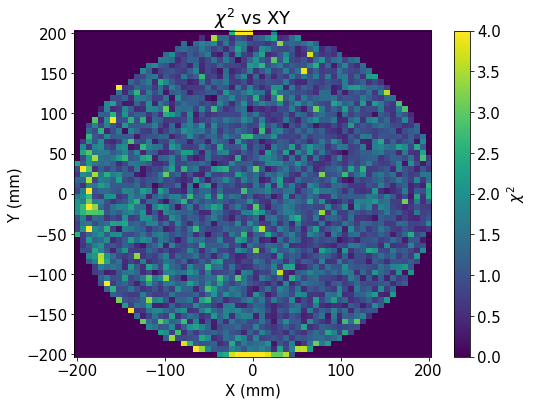

In [62]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1)
#plt.subplot(1, 1, 1)
*_, cb = display_matrix(krBins.cXY, krBins.cXY, Echi2, mask=valid,
                        vmin = 0, vmax = 4,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("$\chi^2$")
labels("X (mm)", "Y (mm)", "$\chi^2$ vs XY")

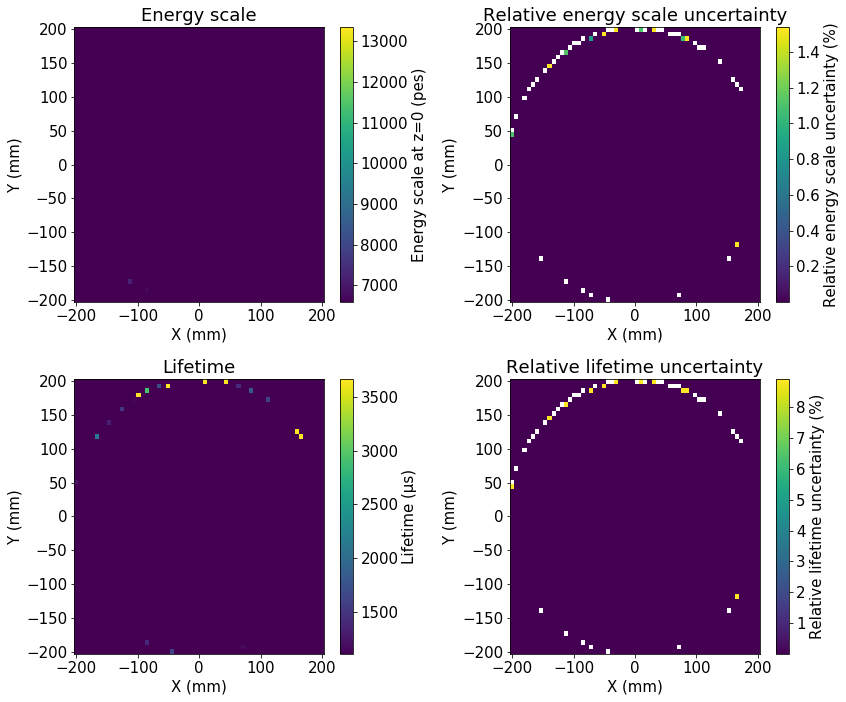

In [63]:
krp.figsize("L")
krp.display_lifetime_maps(Escale, ELT, kltl, krBins.cXY, cmap="viridis", mask=invalid)

### Fix map

- Fit fails in the corona
- Fill bins where fit has failed with average low level of lifetime


In [64]:
Escale_abs_corr = Measurement(np.where(valid,  Escale_abs.value ,     es_low), 
                     np.where(valid, Escale_abs.uncertainty,       esu_low ))

ELT_abs_corr = Measurement(np.where(valid,   ELT_abs.value        , lt_low), 
                  np.where(valid,  ELT_abs.uncertainty,    ltu_low))

In [65]:
Escale_corr     = to_relative(Escale_abs_corr, percentual=True)  # errors in %
ELT_corr        = to_relative(ELT_abs_corr, percentual=True)

In [66]:
#krp.display_lifetime_maps(Escale_corr, ELT_corr, kltl, krBins.cXY, 
 #                         cmap="viridis", mask=None)

In [67]:
gvalid   = np.zeros((krNBins.XY,krNBins.XY), dtype=bool)

In [68]:
def gfid(gvalid):
    for i in range(krNBins.XY):
        for j in range(krNBins.XY):
            if  np.sqrt(krBins.cXY[i]**2 + krBins.cXY[j]**2) < krRanges.XY[1] :
                    gvalid[i, j] = True

In [69]:
gfid(gvalid)

In [70]:
np.count_nonzero(gvalid) / (gvalid.shape[0] * gvalid.shape[1])

0.7855555555555556

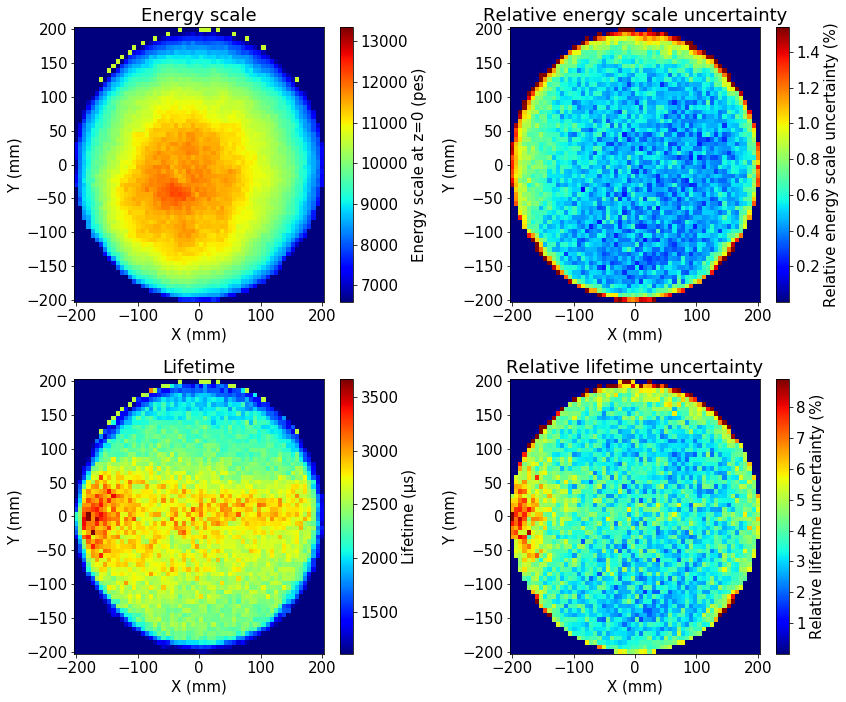

In [71]:
krp.display_lifetime_maps(Escale_corr, ELT_corr, kltl, krBins.cXY, 
                          cmap="jet", mask=gvalid)

### Produce HDF5 output

In [72]:
nevt = nEvt.fid

In [73]:
print(map_filename)

/Users/jjgomezcadenas/Projects/ICDATA/maps/lmap_6224_0000_29999.h5


In [74]:
with tb.open_file(map_filename, "w") as correction_file:
    write_escale = kdstio.xy_writer(correction_file,
                                    group       = "XYcorrections",
                                    name        = "Escale",
                                    description = "XY-dependent energy scale",
                                    compression = "ZLIB4")
    write_escale(krBins.cXY, krBins.cXY, Escale_corr.value, Escale_corr.uncertainty, nevt)
    correction_file.root.XYcorrections.Escale.attrs.xy_bins  = krNBins.XY
    correction_file.root.XYcorrections.Escale.attrs.xy_pitch = krBins.pXY

    write_lifetime = kdstio.xy_writer(correction_file,
                                      group       = "XYcorrections",
                                      name        = "Lifetime",
                                      description = "XY-dependent lifetime values",
                                      compression = "ZLIB4")
    write_lifetime(krBins.cXY, krBins.cXY, ELT_corr.value, ELT_corr.uncertainty, nevt)
    correction_file.root.XYcorrections.Lifetime.attrs.xy_bins  = krNBins.XY
    correction_file.root.XYcorrections.Lifetime.attrs.xy_pitch = krBins.pXY



### Load Z correction function

In [75]:
ZcorrectionE = dstf.load_lifetime_xy_corrections(map_filename,
                                                 group = "XYcorrections",
                                                 node  = "Lifetime")

### Correct DST by lifetime

In [76]:
E = np.copy(dst.S2e.values)

In [77]:

dst.S2e = dst.S2e.values * ZcorrectionE(dst.Z, dst.X, dst.Y).value

In [78]:
Ec = dst.S2e.values

{'Ecorr ': Measurement(value=9826.1084060700705, uncertainty=1705.8341800165354),
 'Eraw ': Measurement(value=8796.9281271935088, uncertainty=1719.5876733920175)}

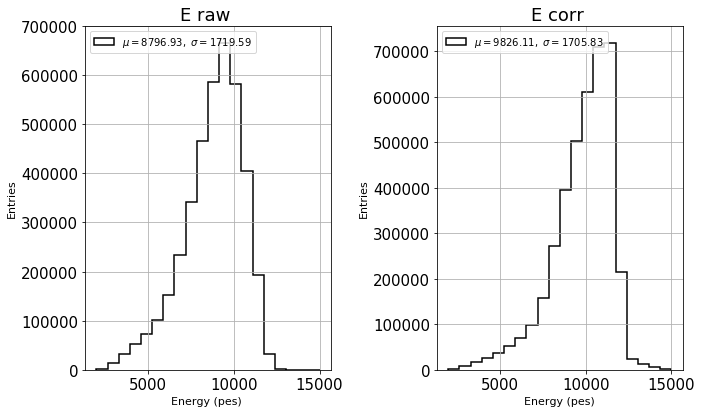

In [79]:
krh.h1n(n=2, nx=1, ny=2, 
    h1ds = (E, Ec),
    bins = (20, 20),
    names = ("Eraw ", "Ecorr "),
    ranges = (( 2e3, 15e3), ( 2e3, 15e3)),
    xlabels = ("Energy (pes) ", "Energy (pes)"),
    ylabels = ("Entries", "Entries"),
    titles = ("E raw ", "E corr "),
    legends = ("upper left", "upper left"),
    figsize =(10,6))

### Time profile

In [80]:
kdstc= kr_event(dst)

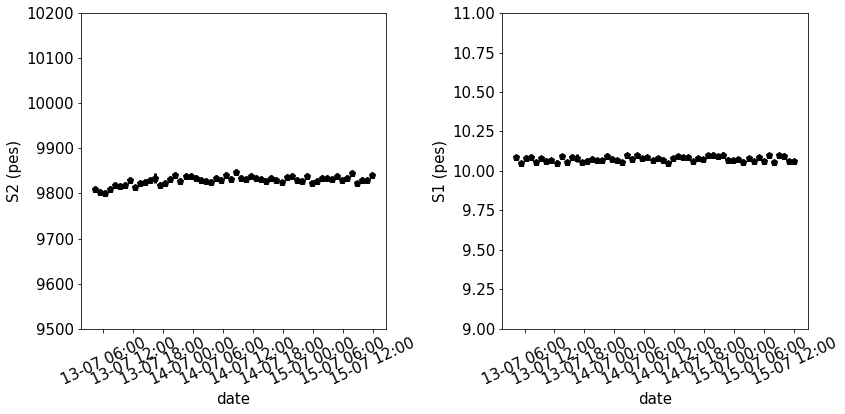

In [81]:
krf.s12_time_profile(kdstc, krNBins.T, krRanges.T, krTimes.timeStamps, s2lim=(9500, 10200), s1lim=(9,11), figsize=(12,6))

### Time correction

In [82]:
e_mu    = np.nanmean(kdstc.E)
print(e_mu)
e_std   = np.nanstd (kdstc.E)
print(e_std)

9829.29876192
1710.38988235


In [83]:
T   =(kdstc.T - kdstc.T.min()) 
t, e, eu = fitf.profileX(T, kdstc.E, 100)
ET_correction = corrf.Correction((t,), e, eu,
                                 norm_strategy =  "const",
                                 norm_opts     = {"value": e_mu})
Ekr = kdstc.E * ET_correction(T).value
tc, ec, euc = fitf.profileX(T, Ekr, 100)

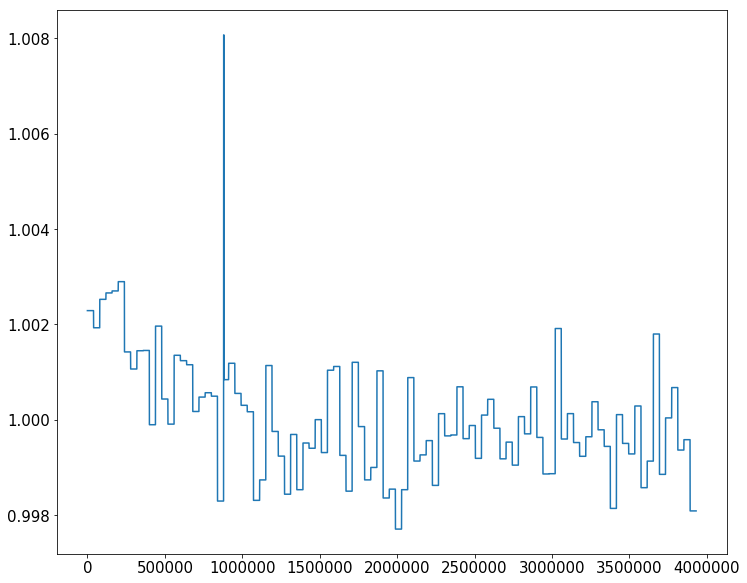

In [84]:
plt.plot(ET_correction(T).value)

In [85]:
ekr_mu    = np.nanmean(Ekr)
ekr_std   = np.nanstd (Ekr)
print(ekr_mu)
print(ekr_std)

9829.29897309
1710.36005692


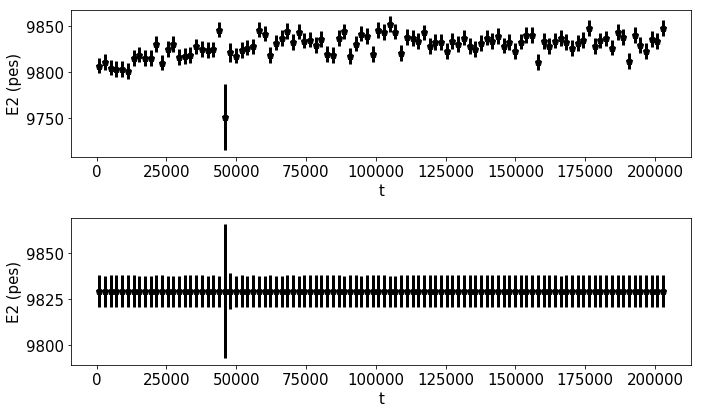

In [86]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(2, 1, 1)

plt.errorbar(t, e, eu, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E2 (pes)')

ax = fig.add_subplot(2, 1, 2)

plt.errorbar(tc, ec, euc, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E2 (pes)')
plt.tight_layout()

### Notice scale. Time fluctuation below 1 %

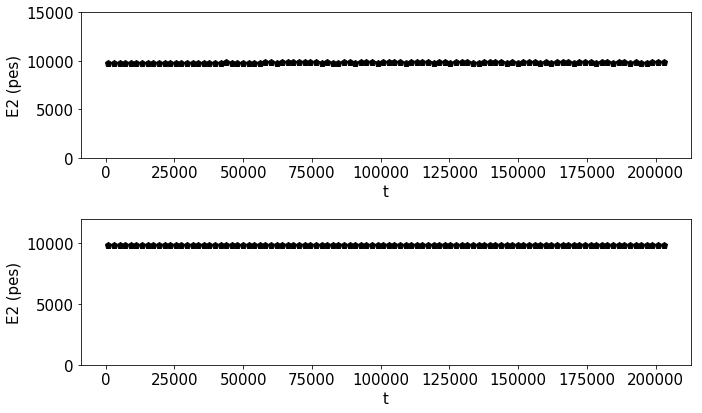

In [87]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(2, 1, 1)
plt.ylim(0, 15000)
plt.errorbar(t, e, eu, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E2 (pes)')

ax = fig.add_subplot(2, 1, 2)
plt.ylim(0, 12000)
plt.errorbar(tc, ec, euc, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E2 (pes)')

plt.tight_layout()



{'E_lt_T_corr ': Measurement(value=9829.2520401824568, uncertainty=1709.6228922547666),
 'E_lt_corr': Measurement(value=9826.1084060700705, uncertainty=1705.8341800165354)}

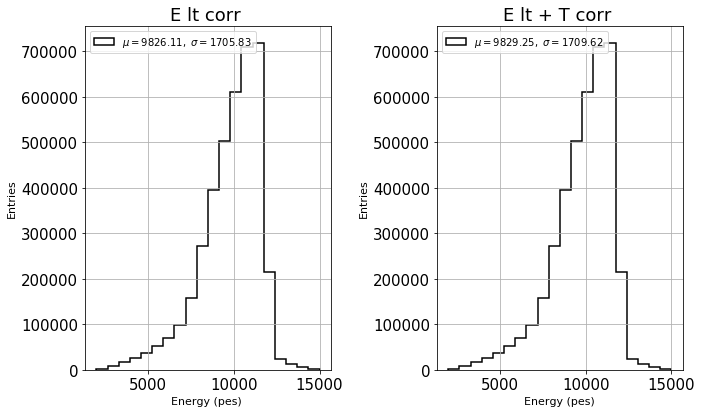

In [88]:
krh.h1n(n=2, nx=1, ny=2, 
    h1ds = (Ec, Ekr),
    bins = (20, 20),
    ranges = (( 2e3, 15e3), ( 2e3, 15e3)),
    xlabels = ("Energy (pes) ", "Energy (pes)"),
    ylabels = ("Entries", "Entries"),
    titles = ("E lt corr ", "E lt + T corr "),
    names = ("E_lt_corr", "E_lt_T_corr "),   
    legends = ("upper left", "upper left"),
    figsize =(10,6))

In [89]:
dst.S2e = Ekr

In [90]:
kdst= fiducial_volumes(dst,
                       R_full   = 200,
                       R_fid    = 150,
                       R_core   = 100,
                       R_hcore  =  50)

 nfull : 3836845: eff_full = 0.976070426440697 
 nfid : 2126195: eff_fid = 0.5408912948910048 
 ncore : 932406: eff_core = 0.23719851128619074 
 nhcore : 232481: eff_hcore = 0.0591417763316891 


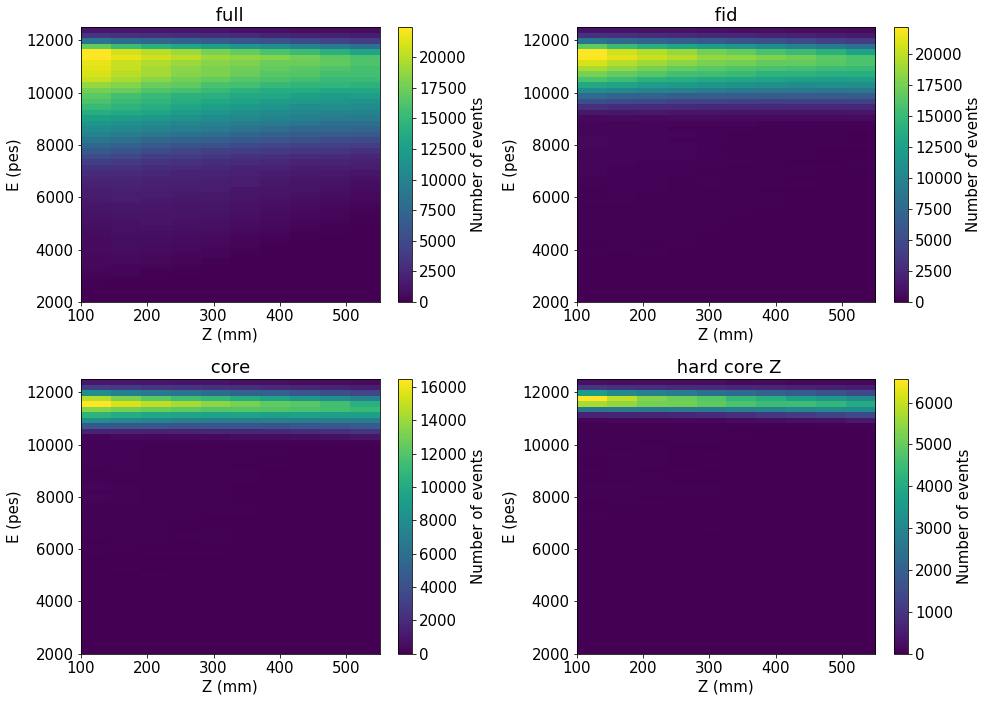

In [91]:
krp.plot_s2_vs_z(kdst, krBins, figsize=(14,10))

In [93]:
del dst["index"]

### Write LT DST

In [94]:

dst.to_hdf(output_dst_filename,
              key     = "DST"  , mode         = "w",
              format  = "table", data_columns = True,
              complib = "zlib" , complevel    = 4)

with tb.open_file(output_dst_filename, "r+") as f:
    f.rename_node(f.root.DST.table, "Events")
    f.root.DST.Events.title = "Events"

